# SST1 NEXAFS Processing Notebook

Takes raw SST1 output and can plot/export:
* Normalized NEXAFS data for each measured angle
* Extrapolated NEXAFS to total isotropy anisotropy (applicable only to uniaxial samples)
* Binary contrasts in a variety of data formats (animated gif)
* CyRSoXS materials.txt files

In [1]:
# # # Only needs to be run once per session, restart kernel after running

# # %pip install pyhyperscattering==0.2.1  # to use pip published package
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory
!pip install --pre --upgrade tiled[all] databroker  # bottleneck # needed to fix tiled/databroker error in SST1RSoXSDB

Obtaining file:///nsls2/users/alevin/repos/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0.2.1+37.gac1f562-0.editable-py3-none-any.whl size=5355 sha256=f1e0133d0147fea3b796ba6cca27fb28fa347d5b78a1531dbd834f24cfa079a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6jze5aw/wheels/7d/89/c7/db1d0cb1cf714f3a03a438abee7b78ce09921efd15259b1f5f
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0.2.1+37.gac1f562
    Uninstalling PyHyperScattering-0.2.1+37.gac1f562:
      Successfully uninstalled PyHyperScattering-0.2.1+37.gac1f562


In [2]:
!pip install -e /nsls2/users/alevin/repos/kkcalc

Obtaining file:///nsls2/users/alevin/repos/kkcalc
  Preparing metadata (setup.py) ... done
  Running setup.py develop for kkcalc


In [4]:
# !pip install -e /nsls2/users/alevin/repos/xarray

## Imports

In [1]:
# Imports:
import kkcalc
from kkcalc import data
from kkcalc import kk
import pathlib
import json 
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import dask.array as da
from scipy import optimize
import sys
from tqdm.auto import tqdm

# from tiled.client import from_profile
# import PyHyperScattering as phs
# print(f'Using PyHyperScattering Version: {phs.__version__}')

sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
import nexafs_fxns as nf  # custom nexafs functions used throughout this notebook

In [32]:
# Imports:
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import optimize
import dask.array as da
from tqdm.auto import tqdm

sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
import nexafs_fxns as nf  # custom nexafs functions used throughout this notebook

## Define paths & short functions

In [2]:
# Define directory paths
userPath = pathlib.Path('/nsls2/users/alevin')
# propPath = pathlib.Path('/nsls2/data/sst/proposals/2022-2/pass-309180')
# propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-2/pass-311130')
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-3/pass-313412')
outPath = propPath.joinpath('processed_data')
zarrsPath = outPath.joinpath('zarrs')

In [3]:
# Some user defined functions for loading metadata
def load_nexafs(loader, run):
    monitors = loader.loadMonitors(run)
    energies = monitors['energy_readback']
    monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    # monitors = monitors.rename({'time_bins':'time'}).rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    theta = int(np.round(run['baseline']['data']['en_sample_polarization'][0], 0))
    
    if theta > 90:
        theta = 180 - theta
        
    monitors = monitors.expand_dims({'theta': [theta],
                                     'sample_name': [run.start['sample_name']]})
    monitors = monitors.assign_coords({'scan_id': ('theta', [run.start['scan_id']]),
                                       'sample_id': ('sample_name', [run.start['sample_id']])})
    monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
    return monitors    


# def load_trmsn_diode_nexafs(loader, run, theta_val):
#     monitors = loader.loadMonitors(run)
#     energies = monitors['en_monoen_readback']
#     monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
#     # theta = int(np.round(run['baseline']['data']['en_sample_polarization'][0], 0))
#     # theta = [45.0, 55.0, 90.0]  # Not actually true for 55.0, since that would correspond to 35° lab pol and I am selecting the 22.8° lab pol
#     monitors = monitors.expand_dims({'theta': [theta_val],
#                                      'sample_name': ['diode']})
#     monitors = monitors.assign_coords({'scan_id': ('theta', [run.start['scan_id']])})
#     monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
#     return monitors    


def select_largest_by_energy(dataarrays):
    """
    Given a list of DataArrays, return a list with one DataArray per angle
    and choose the one with the most 'energy' points if there are duplicates.
    """
    # Group by angle
    grouped = {}
    for da in dataarrays:
        angle = int(da.theta)
        if angle not in grouped:
            grouped[angle] = []
        grouped[angle].append(da)

    # Select the DataArray with the most 'energy' points
    selected = []
    for angle, das in grouped.items():
        largest_da = max(das, key=lambda x: x.sizes['energy'])
        selected.append(largest_da)

    return selected

## Load nexafs data from tiled databroker

### Summarize catalog runs

In [37]:
# plan_of_interest = 'nexafs_carbon'

# df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-3', sample_id='', project='', plan=plan_of_interest)

# df

In [6]:
# scan_id = 65578
# lab_pol = c[scan_id]['baseline']['data']['en_polarization_setpoint'][0]
# lab_pol

In [36]:
# plan_of_interest = 'nexafs_fluorine'
# # df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-2', sample_id='diode', project='Calib', plan=plan_of_interest)
# df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-2', sample_id='', project='TEY', plan=plan_of_interest)
# # df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-2', sample_id='_R', project='TRMSN', plan=plan_of_interest)
# # df = loader.summarize_run(outputType='default', institution='CUBLDER', cycle='2023-2', sample_id='', project='TRMSN', plan=plan_of_interest)

# df

In [129]:
# # df = df[(df['scan_id']<65886) | (df['scan_id']>=65947)]
# df = df[(df['scan_id']<65910) | (df['scan_id']>65933)]
# # df = df[(df['scan_id']<65793)]

# df

In [90]:
c = from_profile("rsoxs", structure_clients='numpy')  # create tiled catalog needed for later loaders
loader = phs.load.SST1RSoXSDB(corr_mode='none', catalog=c)

plan_of_interest = 'nexafs_carbon'
df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-3', sample_id='', project='TRMSN', plan=plan_of_interest)
diode_df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2023-3', sample_id='', project='Calibration', plan=plan_of_interest)

display(diode_df)
display(df)

OBJECT CACHE: Will use up to 121_499_065_344 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_065_344 bytes (15% of total physical RAM)


Running catalog search...:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving results...:   0%|          | 0/181 [00:00<?, ?it/s]

Running catalog search...:   0%|          | 0/10 [00:00<?, ?it/s]

Retrieving results...:   0%|          | 0/9 [00:00<?, ?it/s]

scan_id                 start_time   cycle institution      project  \
0    71139 2023-10-28 07:25:02.744372  2023-3     CUBLDER  Calibration   
1    71140 2023-10-28 07:29:53.025271  2023-3     CUBLDER  Calibration   
2    71141 2023-10-28 07:34:36.347080  2023-3     CUBLDER  Calibration   
3    71142 2023-10-28 07:39:17.025200  2023-3     CUBLDER  Calibration   
4    71143 2023-10-28 07:49:49.147577  2023-3     CUBLDER  Calibration   
5    71513 2023-10-29 21:50:05.943436  2023-3     CUBLDER  Calibration   
6    71514 2023-10-29 21:53:50.944142  2023-3     CUBLDER  Calibration   
7    71515 2023-10-29 21:57:24.428360  2023-3     CUBLDER  Calibration   
8    71516 2023-10-29 22:01:00.944968  2023-3     CUBLDER  Calibration   

     sample_name      sample_id           plan  detector  sample_pol  \
0  diode_grazing  diode_grazing  nexafs_carbon  waxs_det   20.000000   
1  diode_grazing  diode_grazing  nexafs_carbon  waxs_det   29.989581   
2  diode_grazing  diode_grazing  nexafs_carbon  waxs_det   55.004986   
3  diode_grazing  diode_grazing  nexafs_carbon  waxs_det   70.047954   
4  diode_grazing  diode_grazing  nexafs_carbon  waxs_det   89.636465   
5          diode          diode  nexafs_carbon  waxs_det   90.000000   
6          diode          diode  nexafs_carbon  waxs_det   90.000000   
7          diode          diode  nexafs_carbon  waxs_det   90.000000   
8          diode          diode  nexafs_carbon  waxs_det   90.000000   

    lab_pol exit_status  num_Images      sample_id  
0    [0, 0]     success         415  diode_grazing  
1  [22, 22]     success         415  diode_grazing  
2  [52, 52]     success         415  diode_grazing  
3  [68, 68]     success         945  diode_grazing  
4  [90, 90]     success         412  diode_grazing  
5    [0, 0]     success         314          diode  
6  [45, 45]     success         315          diode  
7  [65, 65]     success         315          diode  
8  [90, 90]     success         315          diode

scan_id                 start_time   cycle institution  \
0      71269 2023-10-28 21:18:30.346709  2023-3     CUBLDER   
1      71270 2023-10-28 21:35:19.425674  2023-3     CUBLDER   
2      71271 2023-10-28 21:39:01.422924  2023-3     CUBLDER   
3      71272 2023-10-28 21:42:35.237623  2023-3     CUBLDER   
4      71273 2023-10-28 21:46:11.944172  2023-3     CUBLDER   
..       ...                        ...     ...         ...   
176    71696 2023-10-30 12:48:58.341711  2023-3     CUBLDER   
177    71697 2023-10-30 12:52:37.946675  2023-3     CUBLDER   
178    71707 2023-10-30 13:33:23.947298  2023-3     CUBLDER   
179    71708 2023-10-30 13:37:08.635661  2023-3     CUBLDER   
180    71709 2023-10-30 13:40:49.223028  2023-3     CUBLDER   

                project        sample_name    sample_id           plan  \
0    TRMSN_RSoXS_NEXAFS  BareSiN_1p5mm_rot   TRMSN2_rot  nexafs_carbon   
1    TRMSN_RSoXS_NEXAFS  BareSiN_1p5mm_rot   TRMSN2_rot  nexafs_carbon   
2    TRMSN_RSoXS_NEXAFS  BareSiN_1p5mm_rot   TRMSN2_rot  nexafs_carbon   
3    TRMSN_RSoXS_NEXAFS  BareSiN_1p5mm_rot   TRMSN2_rot  nexafs_carbon   
4    TRMSN_RSoXS_NEXAFS  BareSiN_1p5mm_rot   TRMSN2_rot  nexafs_carbon   
..                  ...                ...          ...            ...   
176  TRMSN_RSoXS_NEXAFS  PM6-Y7BO_CFCN_rot  TRMSN51_rot  nexafs_carbon   
177  TRMSN_RSoXS_NEXAFS  PM6-Y7BO_CFCN_rot  TRMSN51_rot  nexafs_carbon   
178  TRMSN_RSoXS_NEXAFS    PM6-Y6BO_CF_rot  TRMSN45_rot  nexafs_carbon   
179  TRMSN_RSoXS_NEXAFS    PM6-Y6BO_CF_rot  TRMSN45_rot  nexafs_carbon   
180  TRMSN_RSoXS_NEXAFS    PM6-Y6BO_CF_rot  TRMSN45_rot  nexafs_carbon   

     detector  sample_pol   lab_pol exit_status  num_Images    sample_id  
0    waxs_det   55.000000    [0, 0]     success          29   TRMSN2_rot  
1    waxs_det   35.000160    [0, 0]     success         314   TRMSN2_rot  
2    waxs_det   54.998575  [45, 45]     success         315   TRMSN2_rot  
3    waxs_det   70.002516  [65, 65]     success         314   TRMSN2_rot  
4    waxs_det   89.683099  [90, 90]     success         315   TRMSN2_rot  
..        ...         ...       ...         ...         ...          ...  
176  waxs_det   54.998496  [45, 45]     success         315  TRMSN51_rot  
177  waxs_det   89.683098  [90, 90]     success         315  TRMSN51_rot  
178  waxs_det   35.000000    [0, 0]     success         313  TRMSN45_rot  
179  waxs_det   54.998496  [45, 45]     success         313  TRMSN45_rot  
180  waxs_det   89.683098  [90, 90]     success         313  TRMSN45_rot  

[181 rows x 14 columns]

In [97]:
with pd.option_context('display.max_rows', None):
    display(df[97:])

scan_id                 start_time   cycle institution  \
97     71524 2023-10-29 22:28:22.944520  2023-3     CUBLDER   
98     71525 2023-10-29 22:30:53.956141  2023-3     CUBLDER   
99     71526 2023-10-29 22:34:35.239886  2023-3     CUBLDER   
100    71530 2023-10-29 22:48:44.226472  2023-3     CUBLDER   
101    71531 2023-10-29 22:52:27.627893  2023-3     CUBLDER   
102    71532 2023-10-29 22:55:55.826062  2023-3     CUBLDER   
103    71533 2023-10-29 23:01:53.024576  2023-3     CUBLDER   
104    71534 2023-10-29 23:05:37.345241  2023-3     CUBLDER   
105    71535 2023-10-29 23:09:17.824115  2023-3     CUBLDER   
106    71539 2023-10-29 23:21:47.023837  2023-3     CUBLDER   
107    71540 2023-10-29 23:25:30.946940  2023-3     CUBLDER   
108    71541 2023-10-29 23:29:10.744490  2023-3     CUBLDER   
109    71545 2023-10-29 23:43:16.025070  2023-3     CUBLDER   
110    71546 2023-10-29 23:47:01.343521  2023-3     CUBLDER   
111    71547 2023-10-29 23:50:41.823599  2023-3     CUBLDER   
112    71551 2023-10-30 00:04:56.751772  2023-3     CUBLDER   
113    71552 2023-10-30 00:08:41.130982  2023-3     CUBLDER   
114    71553 2023-10-30 00:12:22.349420  2023-3     CUBLDER   
115    71557 2023-10-30 00:24:49.945503  2023-3     CUBLDER   
116    71558 2023-10-30 00:28:34.542146  2023-3     CUBLDER   
117    71559 2023-10-30 00:32:13.825794  2023-3     CUBLDER   
118    71563 2023-10-30 00:48:48.624703  2023-3     CUBLDER   
119    71564 2023-10-30 00:52:33.627637  2023-3     CUBLDER   
120    71565 2023-10-30 00:56:13.947679  2023-3     CUBLDER   
121    71569 2023-10-30 01:10:32.345014  2023-3     CUBLDER   
122    71570 2023-10-30 01:14:17.436566  2023-3     CUBLDER   
123    71571 2023-10-30 01:17:57.623295  2023-3     CUBLDER   
124    71575 2023-10-30 01:30:25.824381  2023-3     CUBLDER   
125    71576 2023-10-30 01:34:11.227637  2023-3     CUBLDER   
126    71577 2023-10-30 01:37:51.222441  2023-3     CUBLDER   
127    71581 2023-10-30 01:50:43.824331  2023-3     CUBLDER   
128    71582 2023-10-30 01:54:28.950326  2023-3     CUBLDER   
129    71583 2023-10-30 01:58:09.348611  2023-3     CUBLDER   
130    71587 2023-10-30 02:12:15.747312  2023-3     CUBLDER   
131    71588 2023-10-30 02:14:46.743554  2023-3     CUBLDER   
132    71589 2023-10-30 02:18:27.350826  2023-3     CUBLDER   
133    71593 2023-10-30 02:29:57.743555  2023-3     CUBLDER   
134    71594 2023-10-30 02:33:42.823986  2023-3     CUBLDER   
135    71595 2023-10-30 02:37:23.743399  2023-3     CUBLDER   
136    71599 2023-10-30 02:51:42.626157  2023-3     CUBLDER   
137    71600 2023-10-30 02:55:31.346031  2023-3     CUBLDER   
138    71601 2023-10-30 02:59:15.025803  2023-3     CUBLDER   
139    71602 2023-10-30 03:05:15.546519  2023-3     CUBLDER   
140    71603 2023-10-30 03:09:03.546419  2023-3     CUBLDER   
141    71604 2023-10-30 03:17:08.744748  2023-3     CUBLDER   
148    71620 2023-10-30 04:09:44.822104  2023-3     CUBLDER   
149    71621 2023-10-30 04:17:49.224912  2023-3     CUBLDER   
150    71622 2023-10-30 04:21:31.224364  2023-3     CUBLDER   
151    71626 2023-10-30 04:35:41.628741  2023-3     CUBLDER   
152    71627 2023-10-30 04:39:26.624002  2023-3     CUBLDER   
153    71628 2023-10-30 04:43:07.425057  2023-3     CUBLDER   
154    71632 2023-10-30 04:56:40.823505  2023-3     CUBLDER   
155    71633 2023-10-30 05:00:26.222713  2023-3     CUBLDER   
156    71634 2023-10-30 05:04:11.023713  2023-3     CUBLDER   
157    71638 2023-10-30 05:16:31.824769  2023-3     CUBLDER   
158    71639 2023-10-30 05:20:17.639346  2023-3     CUBLDER   
159    71640 2023-10-30 05:23:58.223349  2023-3     CUBLDER   
163    71650 2023-10-30 05:55:26.023596  2023-3     CUBLDER   
164    71651 2023-10-30 05:59:13.226051  2023-3     CUBLDER   
165    71652 2023-10-30 06:02:54.745557  2023-3     CUBLDER   
166    71656 2023-10-30 06:15:18.022969  2023-3     CUBLDER   
167    71657 2023-10-30 06:19:03.758614  2023-3     CUBLDER   
168    71658 2023-10-30 06:22:45.426

In [95]:
nitrogen_bad_scans = [71611, 71612, 71613,
                      71698, 71699, 71700,
                      71647, 71648, 71649, 
                      71617, 71618, 71619]

carbon_bad_scans = [71608, 71609, 71610, # PM6-Y6BO_CF_rot
                    71689, 71690, 71691, # PM6-Y6BO_CF_rot
                    71644, 71645, 71646, # PM6-Y7BO_CFCN_rot
                    71614, 71615, 71616] # PM6-Y7_CF_rot

In [96]:
df = df[(~df['scan_id'].isin(carbon_bad_scans))]

In [8]:
# sample_names = df[85:]['sample_name'].unique()
# sample_names

array(['Y7_CBCN_rot', 'Y7BO_CBCN_rot', 'PM6-Y6_CB_rot', 'PM6-Y6BO_CB_rot',
       'PM6-Y7_CB_rot', 'PM6-Y7BO_CB_rot', 'PM6-Y6_CBCN_rot',
       'PM6-Y7_CBCN_rot', 'PM6-Y7BO_CBCN_rot', 'Y6_CFCN_rot',
       'Y6BO_CFCN_rot', 'Y7_CFCN_rot', 'Y7BO_CFCN_rot', 'PM6-Y6_CF_rot',
       'PM6-Y6BO_CF_rot', 'PM6-Y7_CF_rot', 'PM6-Y7BO_CF_rot',
       'PM6-Y6_CFCN_rot', 'PM6-Y6BO_CFCN_rot', 'PM6-Y7_CFCN_rot',
       'PM6-Y7BO_CFCN_rot', 'BareSiN_1mm_rot', 'BareSiN_1mm_rot_1'],
      dtype=object)

### Load data

In [98]:
# Load diode dataset via tiled databroker:
# diode_scan_ids = [71139, 71140, 71141, 71142, 71143]  # carbon nexafs tey angles
# diode_scan_ids = [71144, 71145, 71146, 71147, 71148]  # nitrogen nexafs tey angles

diode_scan_ids = [71513, 71514, 71515, 71516]  # carbon nexafs trmsn angles
# diode_scan_ids = [71517, 71518, 71519, 71520]  # nitrogen nexafs trmsn angles

diode_monitors_list = []
for i, scan_id in enumerate(tqdm(diode_scan_ids)):
    run = c[scan_id]
    diode_monitors = load_nexafs(loader, run)
    diode_monitors_list.append(diode_monitors)

energies = np.linspace(250, 350, 3000)  # carbon
# energies = np.linspace(370, 440, 2000)  # nitrogen

interp_diode_monitors_list = []
for DA in diode_monitors_list:
    DA = DA.interp({'energy':energies})
    interp_diode_monitors_list.append(DA)
    
diode_DS = xr.concat(interp_diode_monitors_list, dim='theta')
diode_DS = diode_DS.assign_coords({'theta':[35, 55, 70, 90]})  # for trmsn angles since they were diode and not diode_grazing
diode_DS

  0%|          | 0/4 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                          (theta: 4, sample_name: 1, energy: 3000)
Coordinates:
  * theta                            (theta) int64 35 55 70 90
  * sample_name                      (sample_name) object 'diode'
    scan_id                          (theta) int64 71513 71514 71515 71516
    sample_id                        (sample_name) <U5 'diode'
  * energy                           (energy) float64 250.0 250.0 ... 350.0
Data variables:
    NSLS-II Ring Current             (energy, theta, sample_name) float64 399...
    RSoXS Au Mesh Current            (energy, theta, sample_name) float64 1.2...
    RSoXS Sample Current             (energy, theta, sample_name) float64 -7....
    RSoXS Shutter Opening Time (ms)  (energy, theta, sample_name) float64 1e+...
    RSoXS Shutter Toggle             (energy, theta, sample_name) float64 1.0...
    RSoXS WAXS Shutter Counter       (energy, theta, sample_name) float64 3.5...
    SAXS Beamstop                    (energy, theta, sample_name) float64 2.2...
    WAXS Beamstop                    (energy, theta, sample_name) float64 4.2...
    energy_readback                  (energy, theta, sample_name) float64 250...
    RSoXS Shutter Toggle_thinned     (energy, theta, sample_name) float64 1.0...
Attributes:
    stream_name:  NSLS-II Ring Current_monitor

In [99]:
# nitrogen_diode_DS = diode_DS.copy()
carbon_diode_DS = diode_DS.copy()

In [100]:
# nitrogen_df = df[85:]
carbon_df = df[97:]

energies = np.linspace(250,350,3000)  # carbon
# energies = np.linspace(370,440,2000)  # nitrogen

# Load full nexafs dataset via tiled databroker:
sample_names = carbon_df['sample_name'].unique()

nf_monitors_full_list = []
for sample_name in tqdm(sample_names):
    runs_of_interest = carbon_df[carbon_df['sample_name']==sample_name]              
    nf_monitors_list = []
    for scan_id in tqdm(runs_of_interest['scan_id']):
        run = c[scan_id]
        nf_monitors = load_nexafs(loader, run)
        nf_monitors_list.append(nf_monitors)

    interp_nf_monitors_list = []
    for DA in select_largest_by_energy(nf_monitors_list):
        DA = DA.interp({'energy':energies})
        interp_nf_monitors_list.append(DA)

    nf_monitors_full = xr.concat(interp_nf_monitors_list, dim='theta')
    nf_monitors_full_list.append(nf_monitors_full)
    
nf_DS = xr.concat(nf_monitors_full_list, dim='sample_name')

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [101]:
# nitrogen_nf_DS = nf_DS.copy()
carbon_nf_DS = nf_DS.copy()

# nitrogen_nf_DS
carbon_nf_DS

<xarray.Dataset>
Dimensions:                          (theta: 3, sample_name: 24, energy: 3000)
Coordinates:
  * theta                            (theta) int64 35 55 90
  * sample_name                      (sample_name) object 'Y7BO_CBCN_rot' ......
    scan_id                          (sample_name, theta) int64 71524 ... 71709
    sample_id                        (sample_name) <U12 'TRMSN29_rot' ... 'TR...
  * energy                           (energy) float64 250.0 250.0 ... 350.0
Data variables:
    NSLS-II Ring Current             (energy, theta, sample_name) float64 399...
    RSoXS Au Mesh Current            (energy, theta, sample_name) float64 1.2...
    RSoXS Sample Current             (energy, theta, sample_name) float64 1.2...
    RSoXS Shutter Opening Time (ms)  (energy, theta, sample_name) float64 1e+...
    RSoXS Shutter Toggle             (energy, theta, sample_name) float64 1.0...
    RSoXS WAXS Shutter Counter       (energy, theta, sample_name) float64 3.5...
    SAXS Beamstop                    (energy, theta, sample_name) float64 3.1...
    WAXS Beamstop                    (energy, theta, sample_name) float64 8.2...
    energy_readback                  (energy, theta, sample_name) float64 250...
    RSoXS Shutter Toggle_thinned     (energy, theta, sample_name) float64 1.0...
Attributes:
    stream_name:  NSLS-II Ring Current_monitor

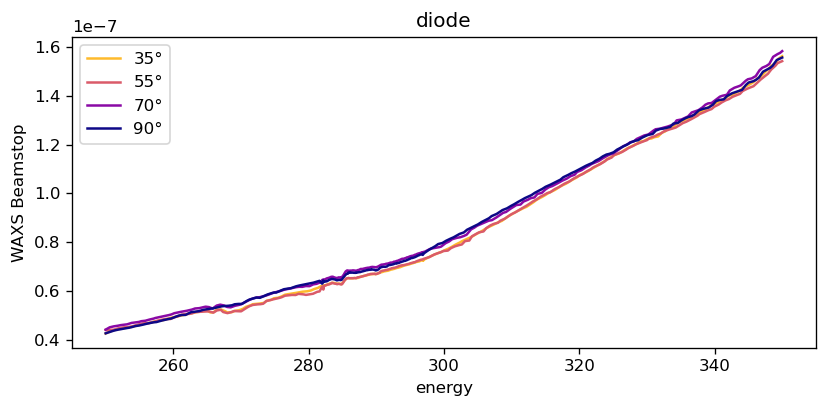

In [102]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nitrogen_diode_DS.theta)))

for sample in carbon_diode_DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(carbon_diode_DS.theta.values):
        # carbon_diode_DS['RSoXS Au Mesh Current'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
        #         ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
        carbon_diode_DS['WAXS Beamstop'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

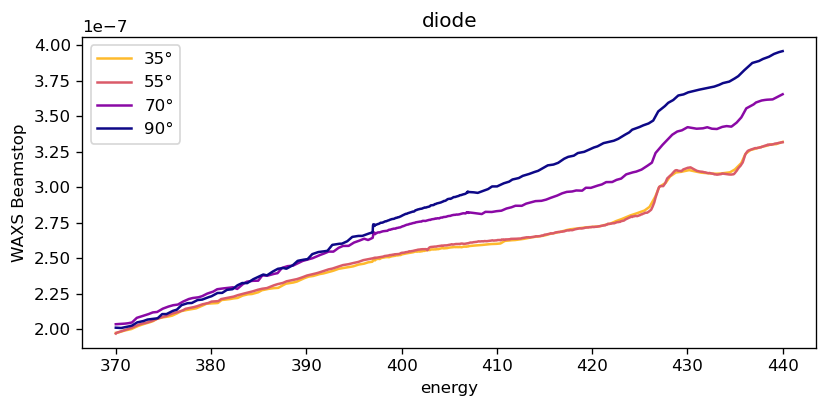

In [53]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nitrogen_diode_DS.theta)))

for sample in nitrogen_diode_DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(nitrogen_diode_DS.theta.values):
        # nitrogen_diode_DS['RSoXS Au Mesh Current'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
        #         ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
        nitrogen_diode_DS['WAXS Beamstop'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

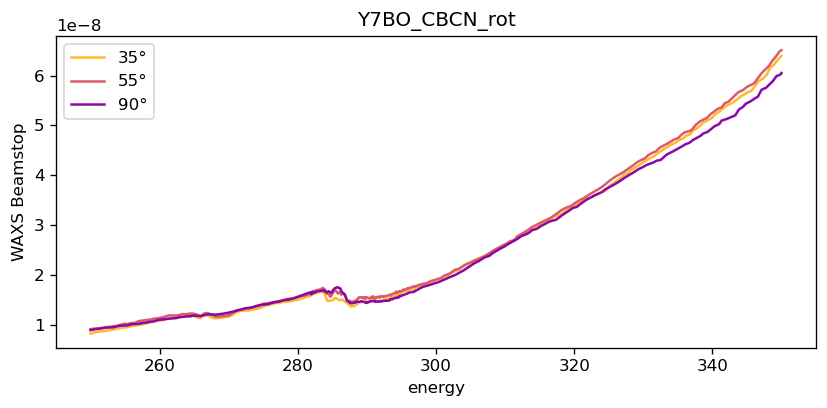

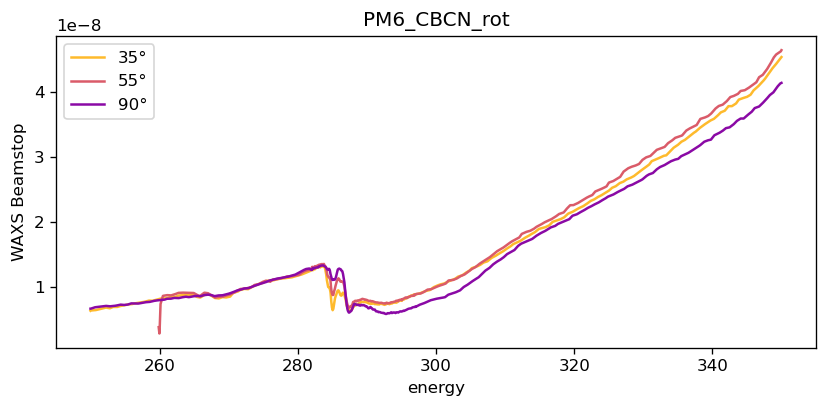

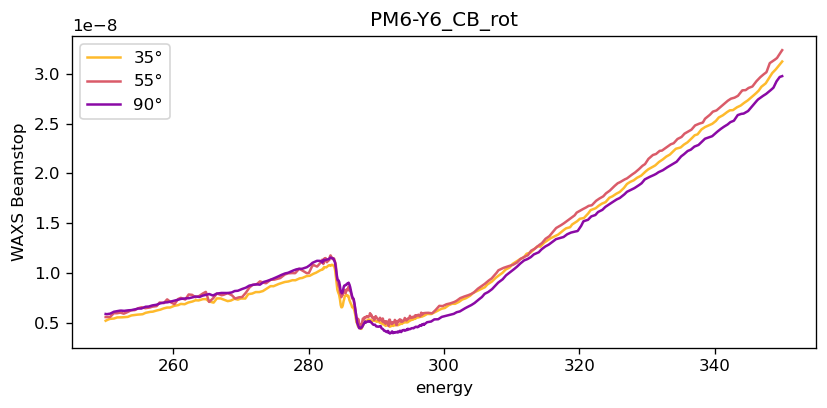

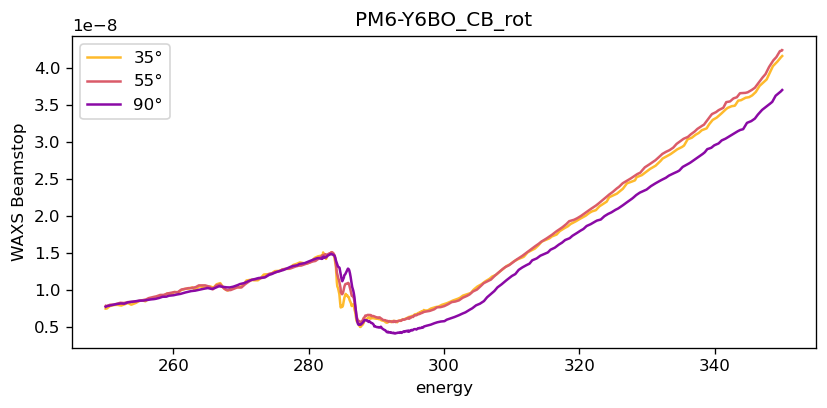

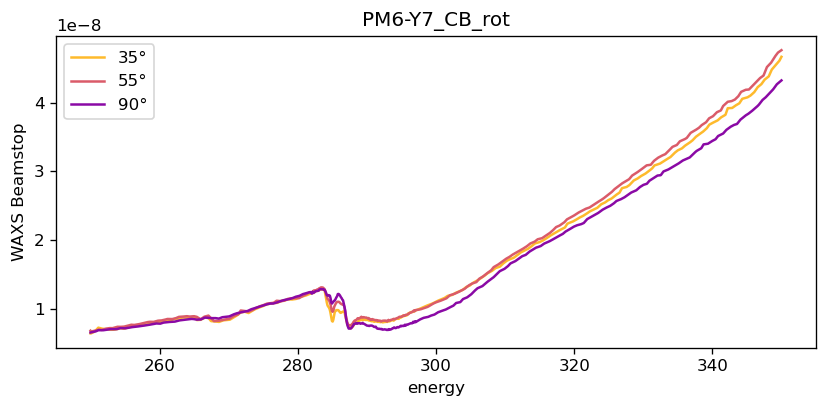

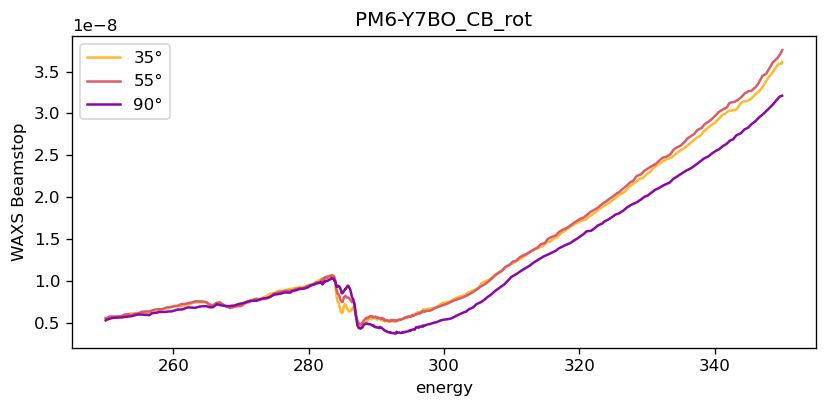

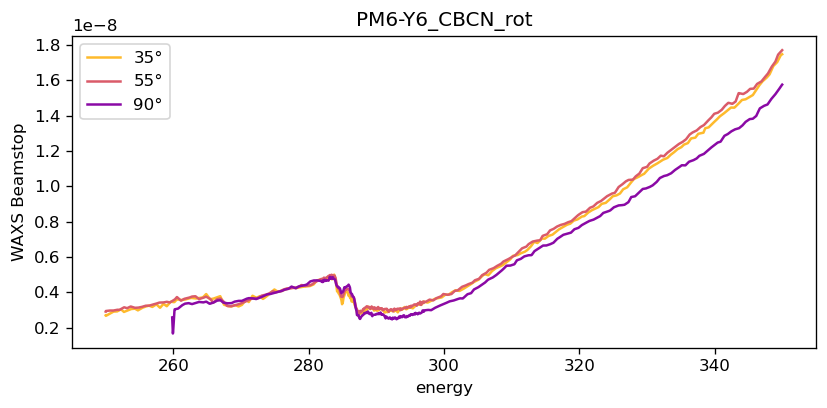

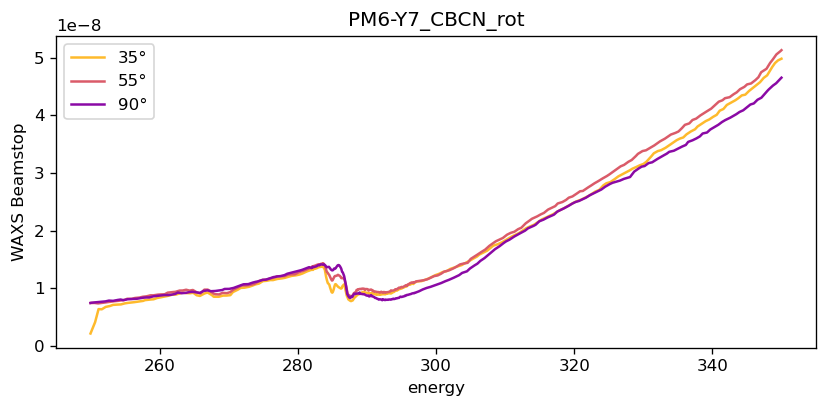

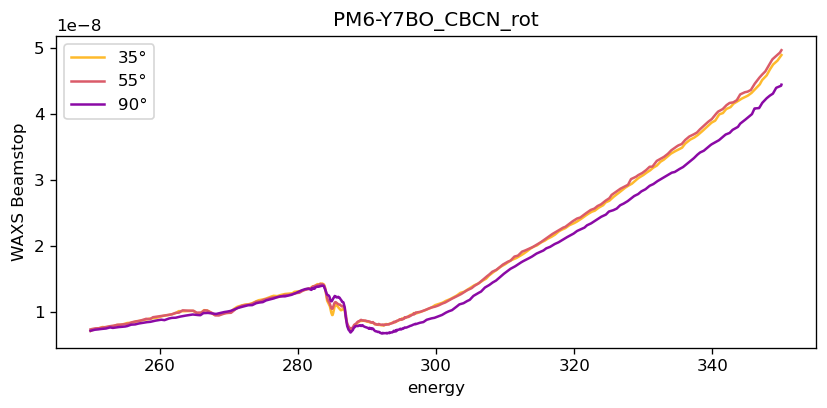

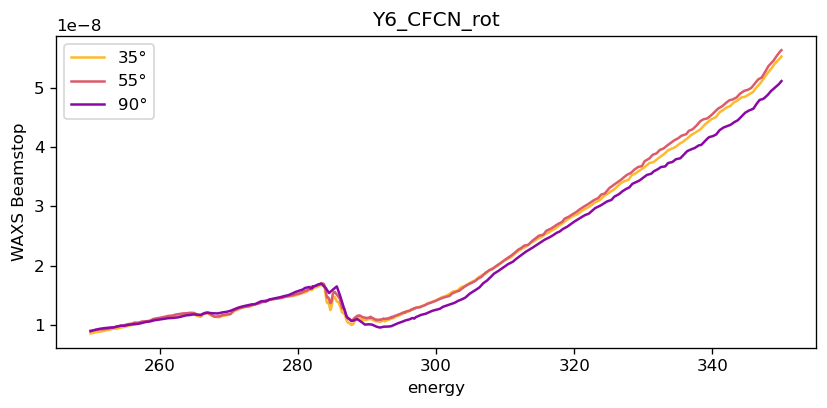

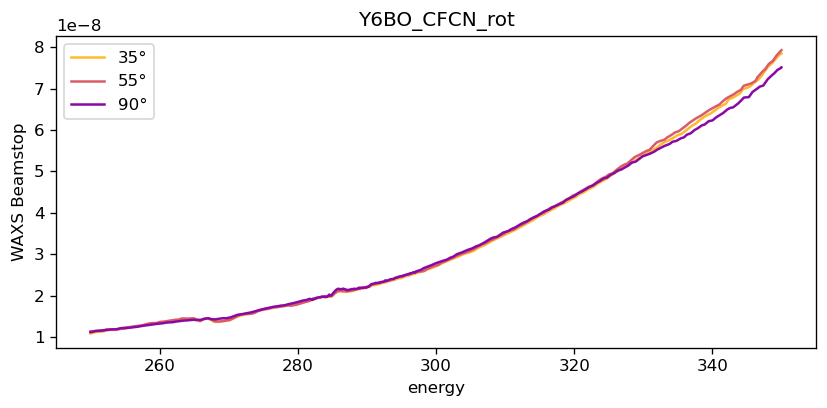

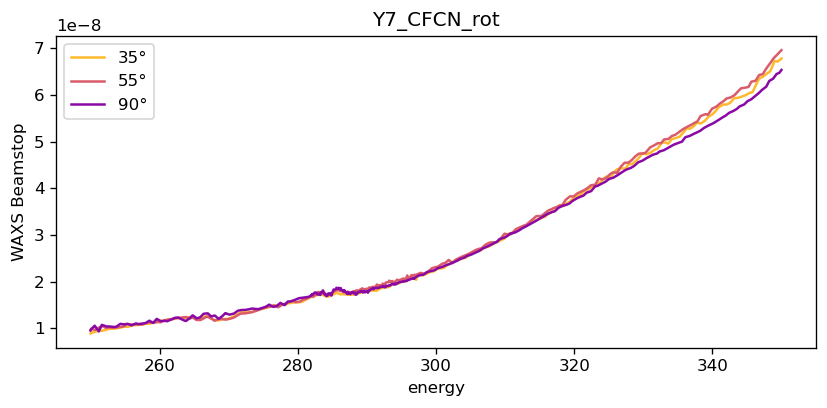

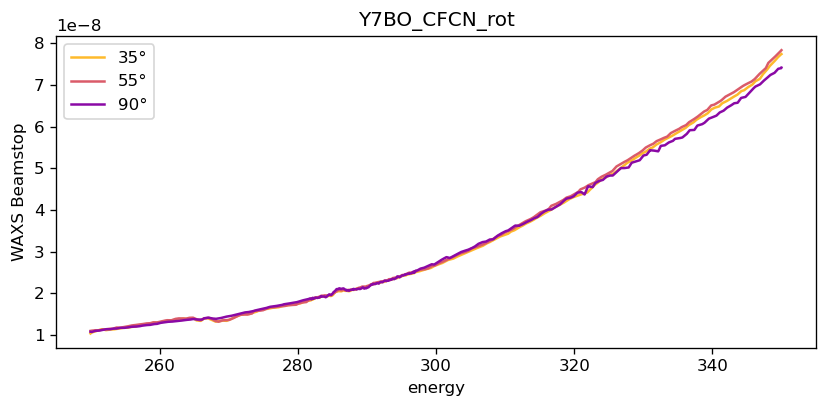

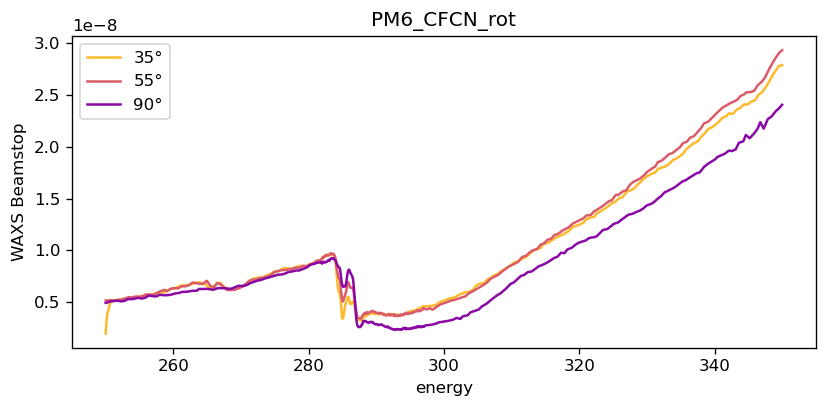

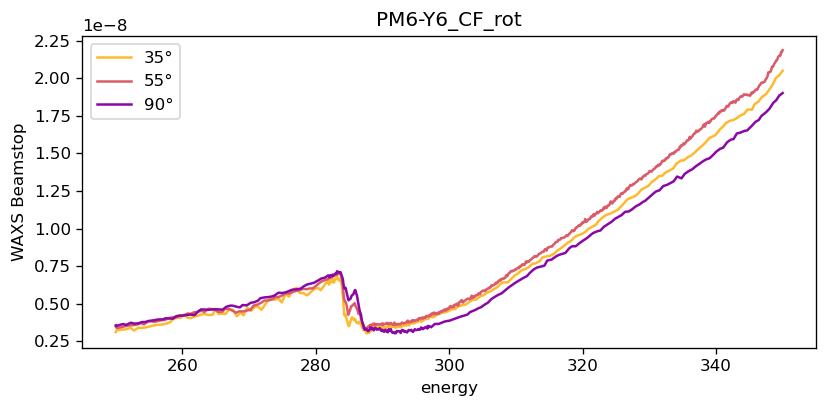

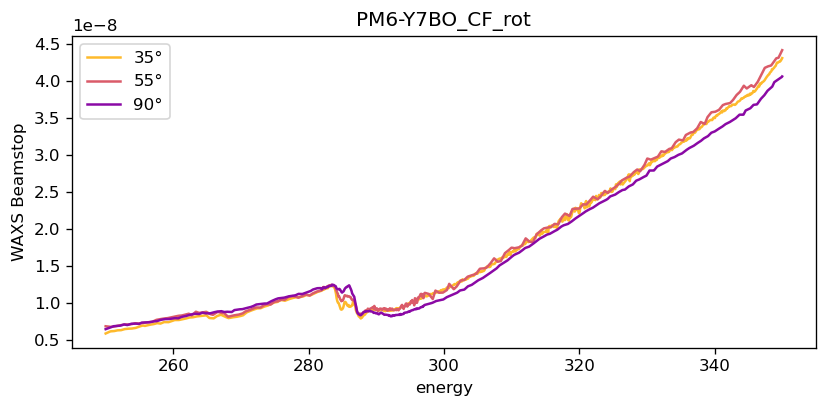

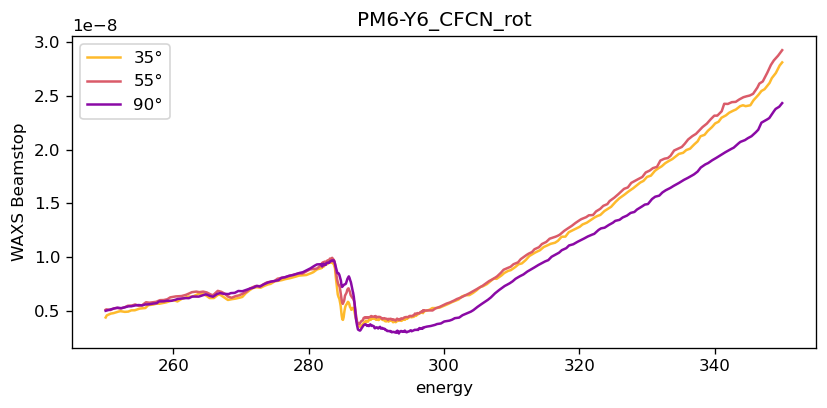

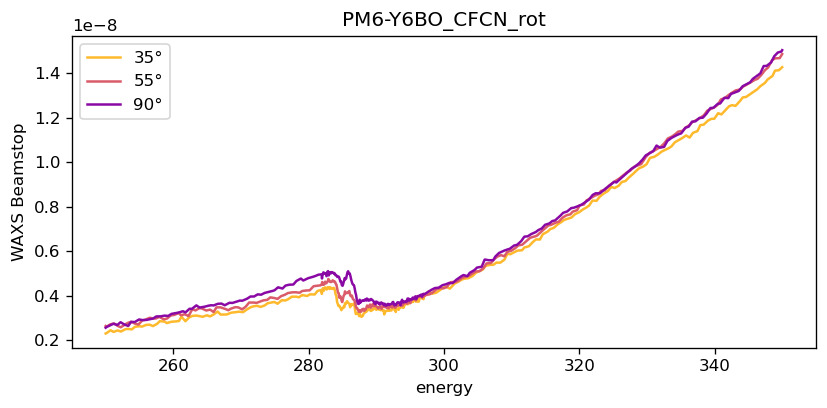

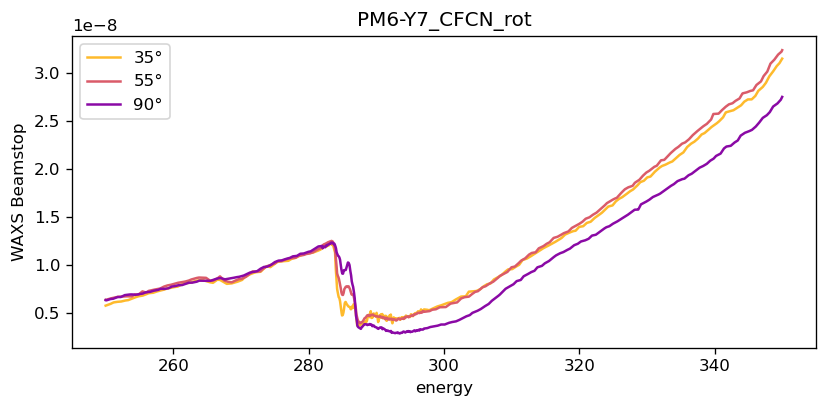

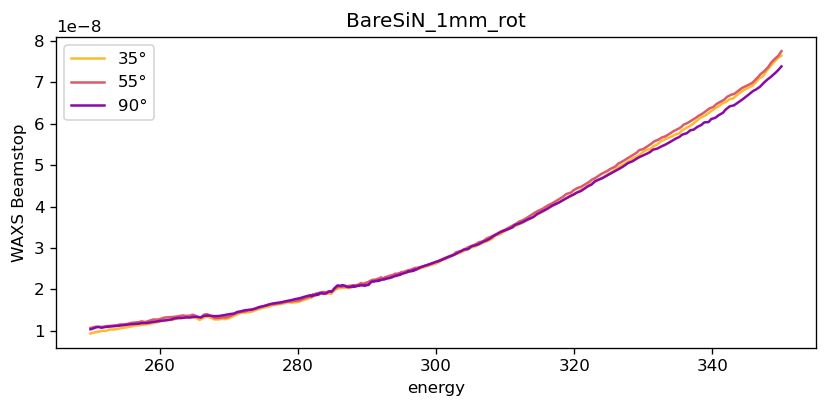

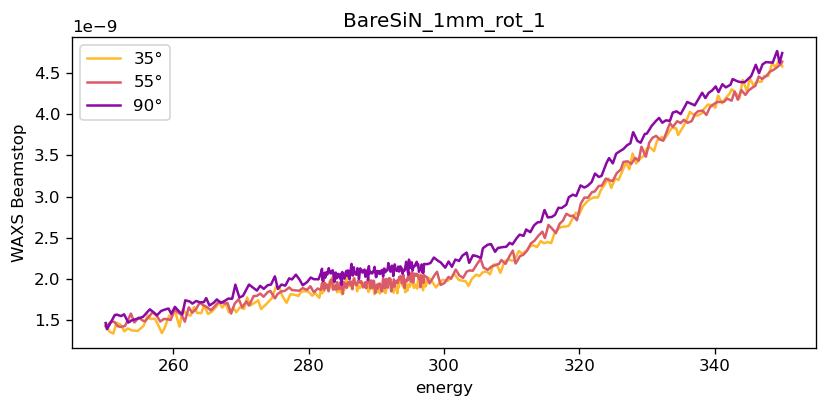

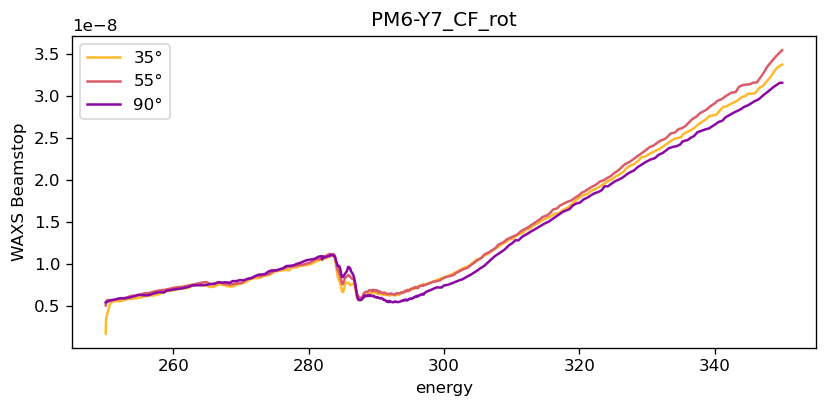

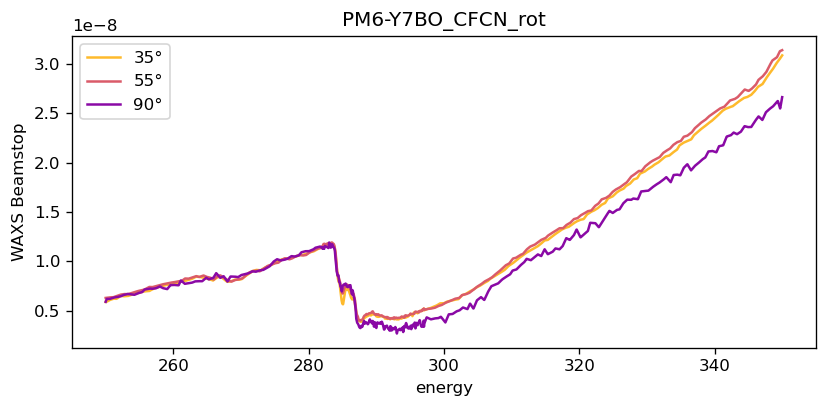

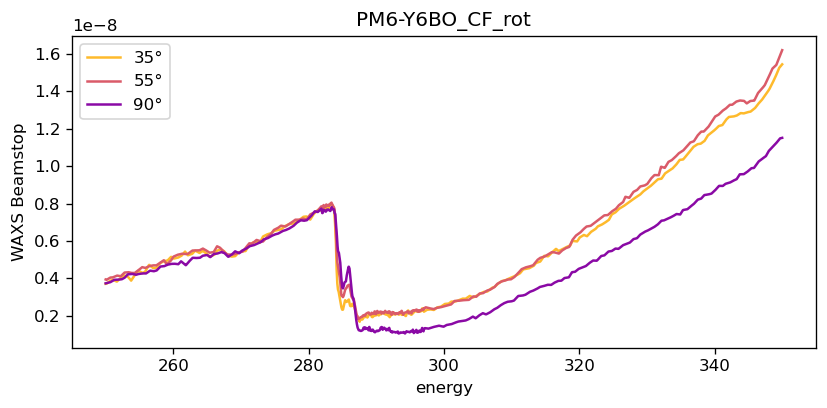

In [103]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nitrogen_diode_DS.theta)))

for sample in carbon_nf_DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(carbon_nf_DS.theta.values):
        # carbon_nf_DS['RSoXS Au Mesh Current'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
        #         ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
        carbon_nf_DS['WAXS Beamstop'].sel(sample_name=sample, theta=theta_val, energy=slice(None, None)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

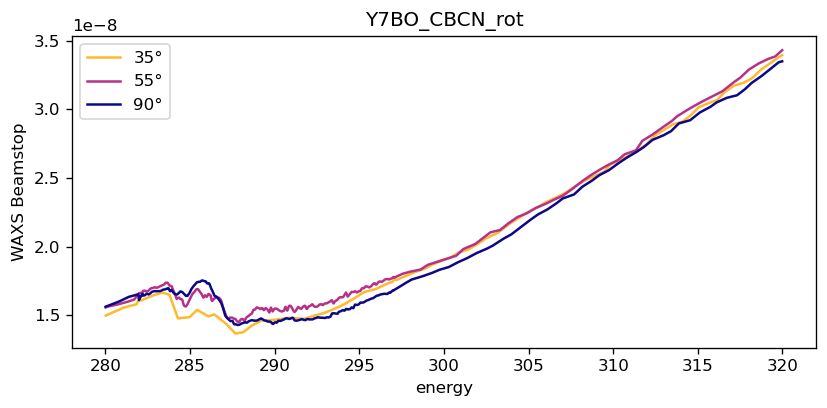

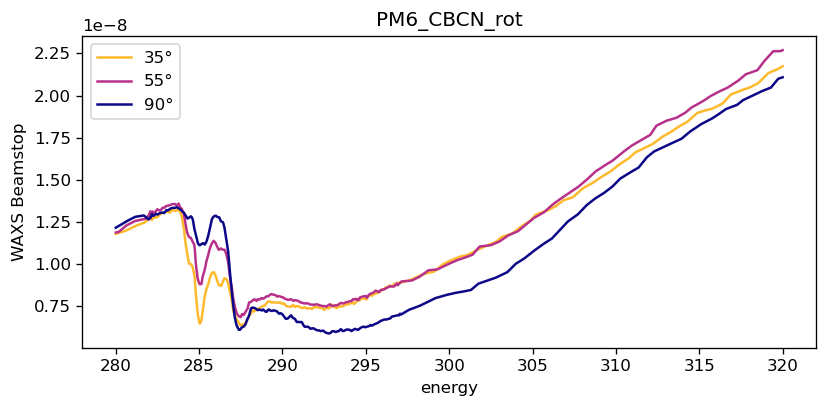

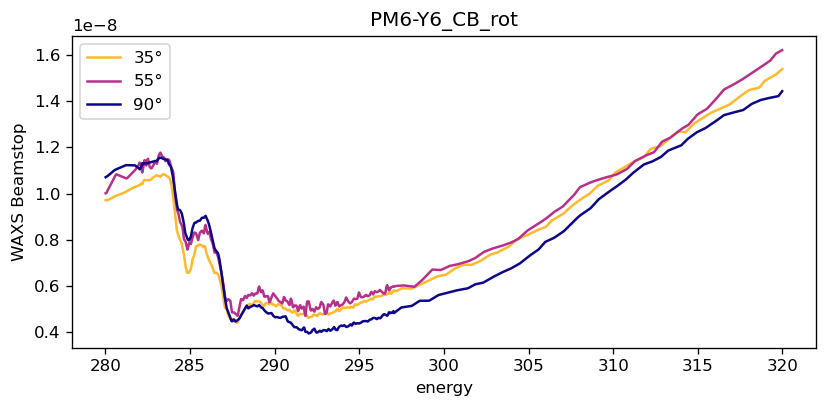

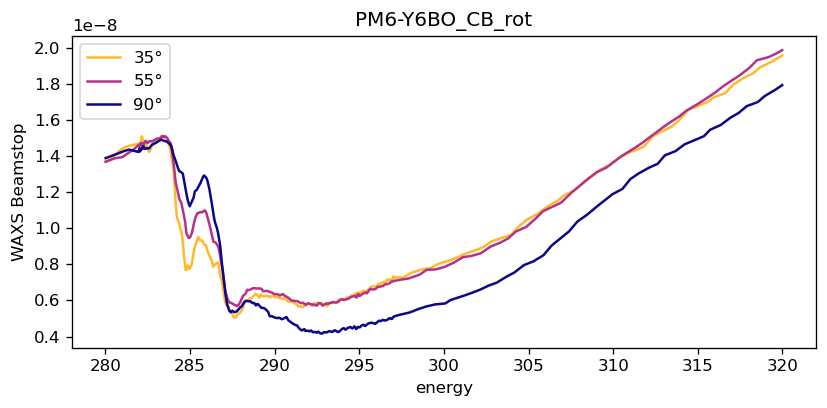

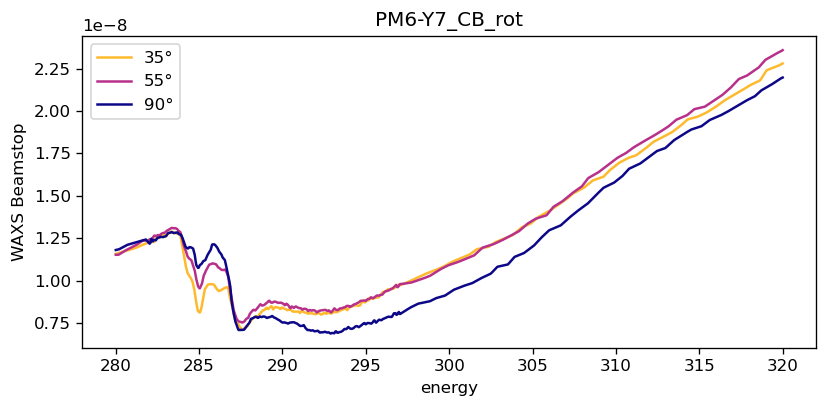

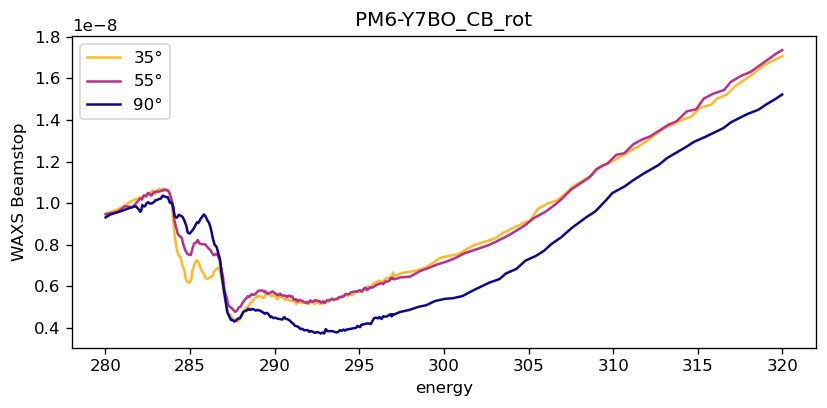

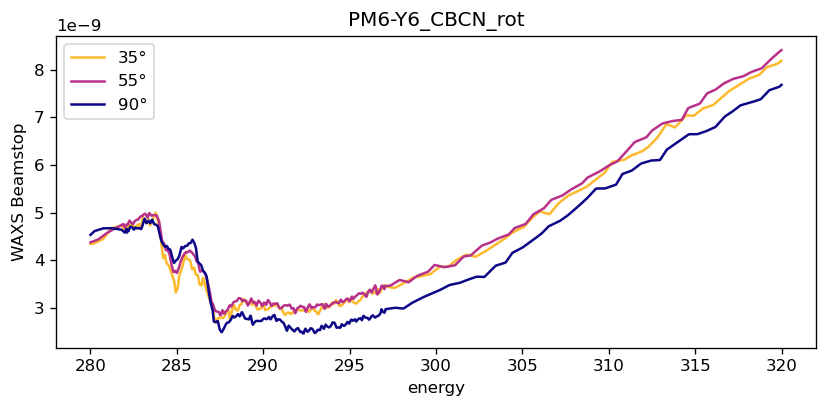

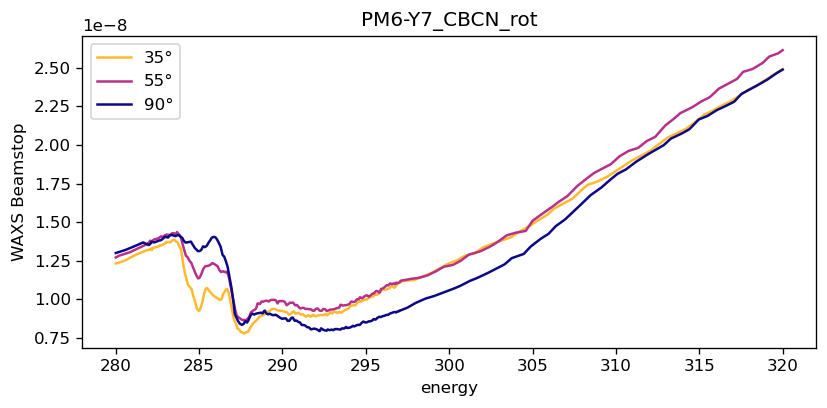

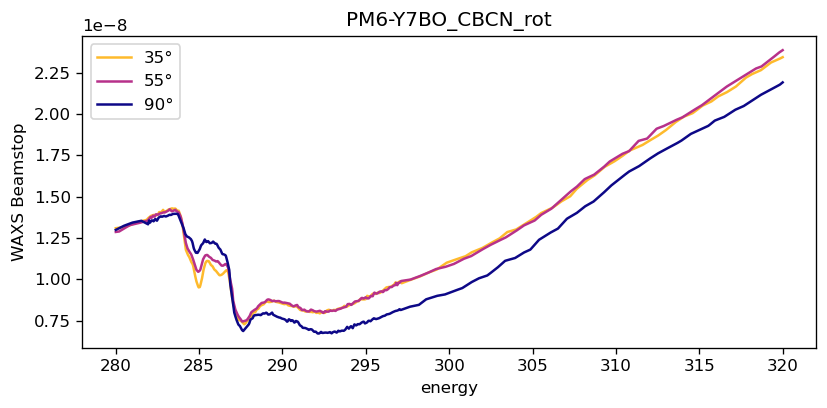

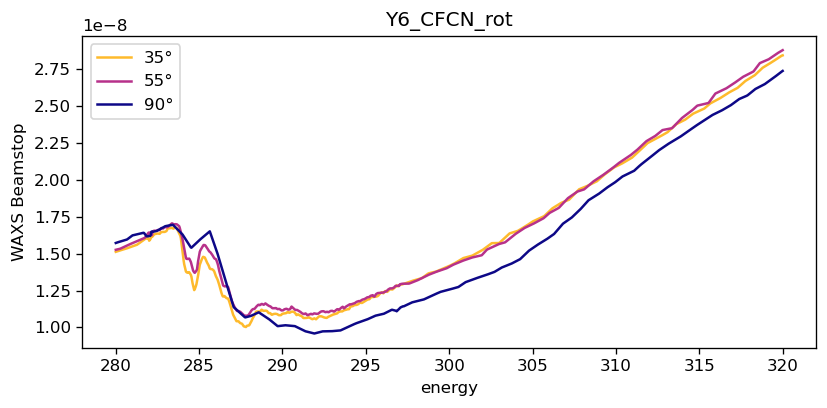

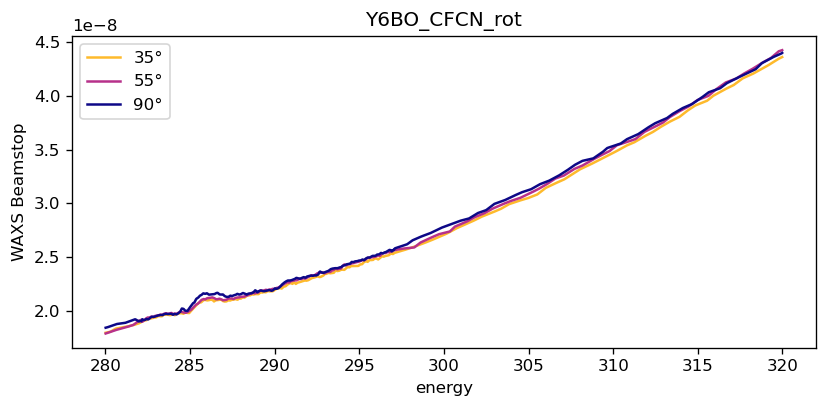

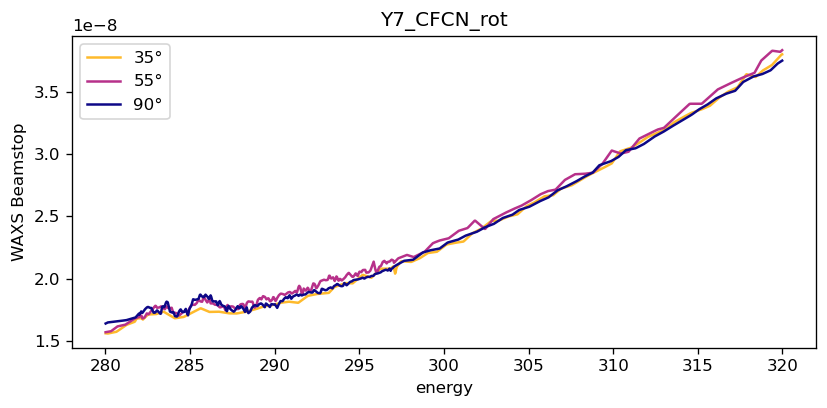

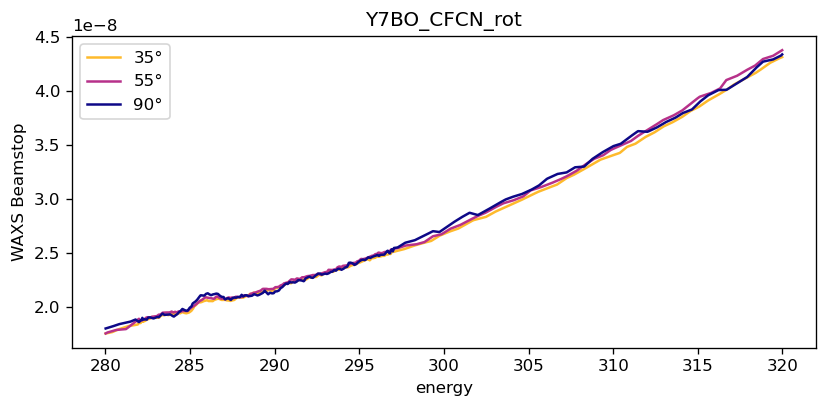

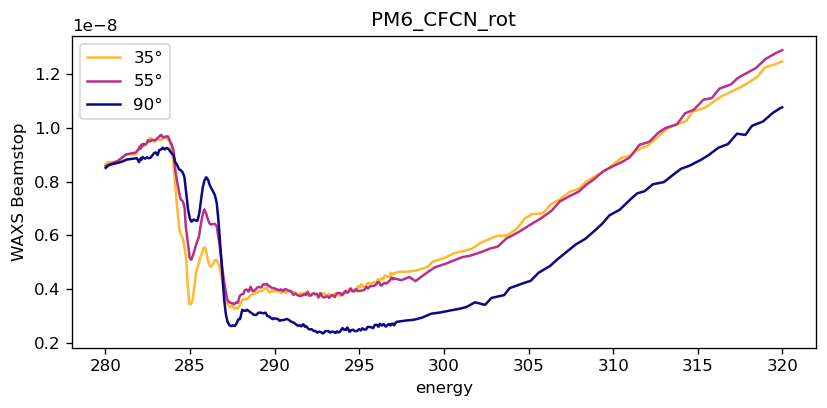

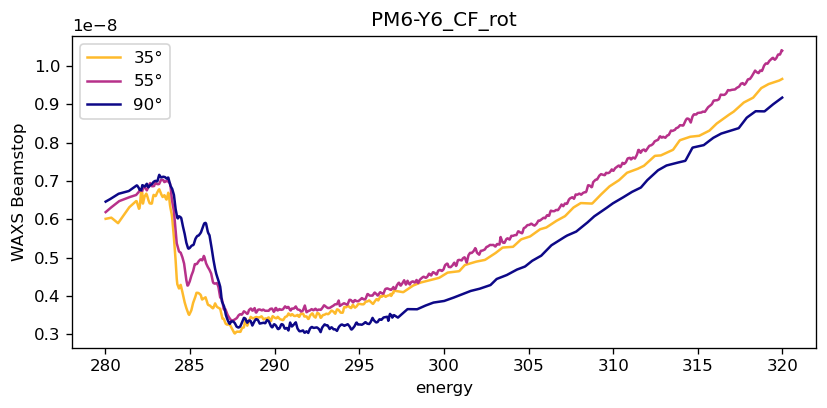

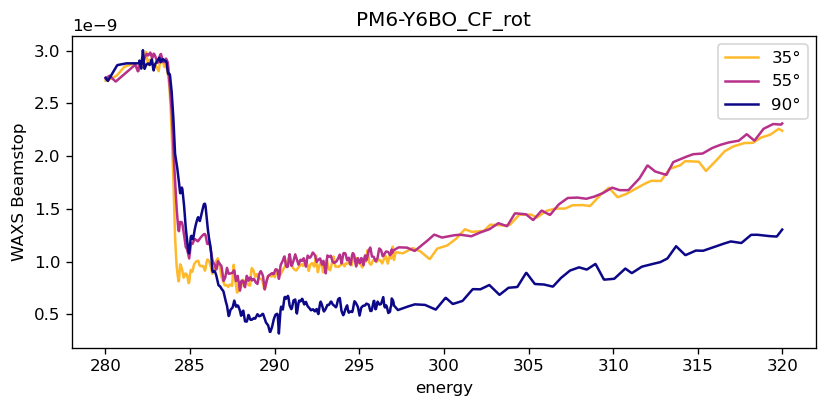

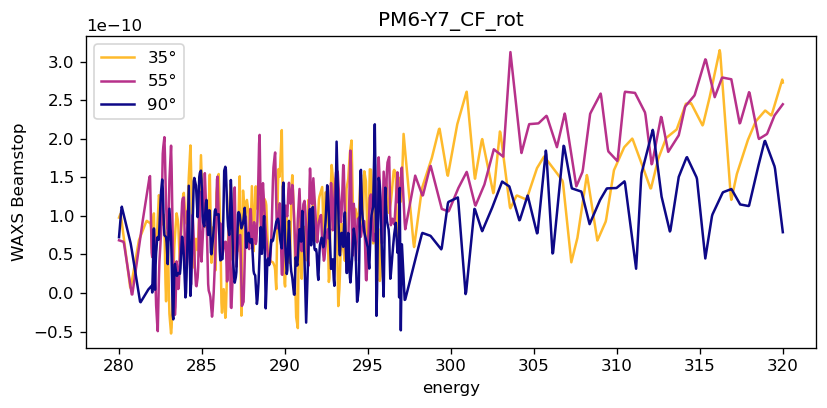

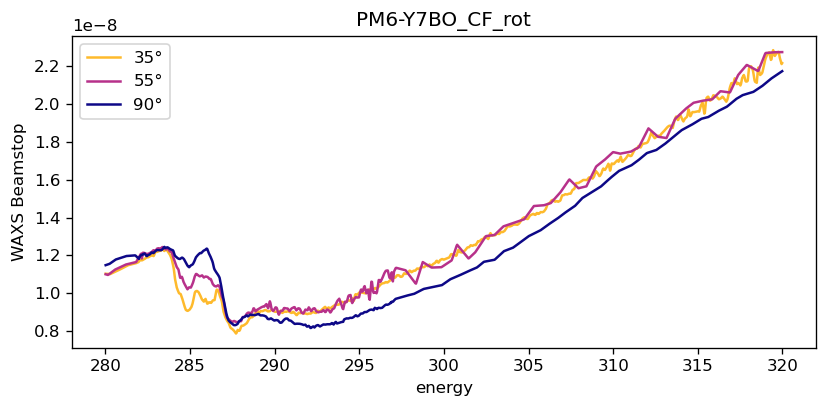

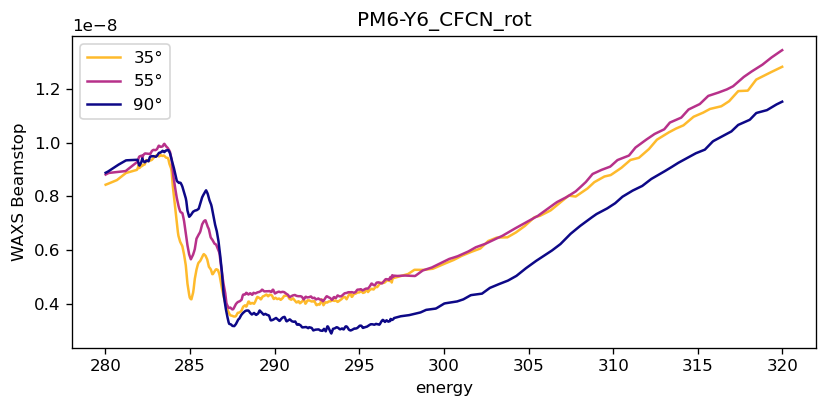

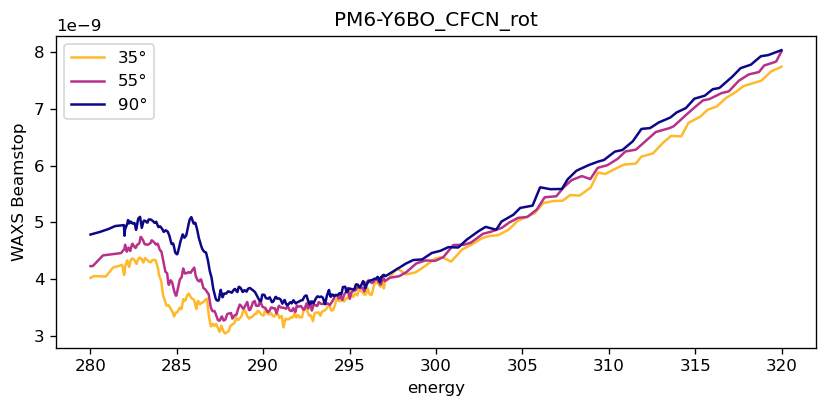

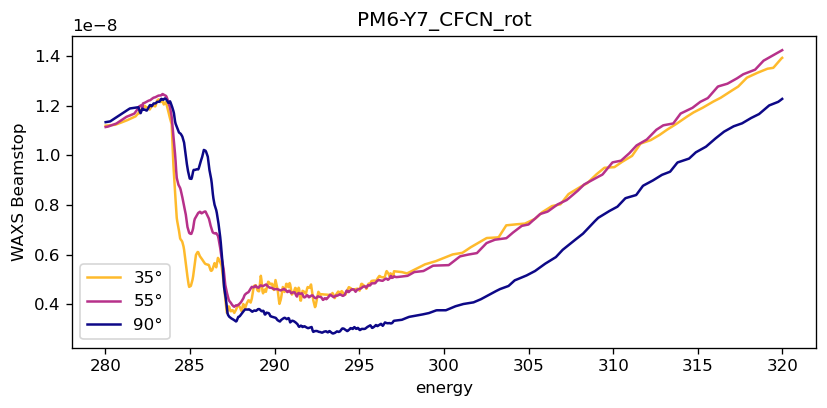

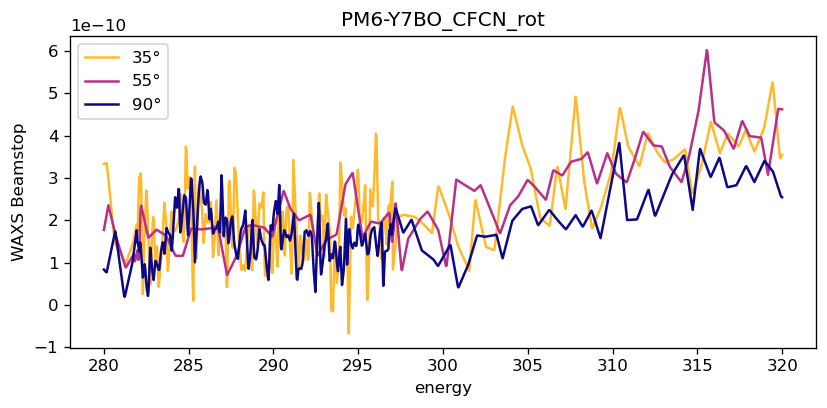

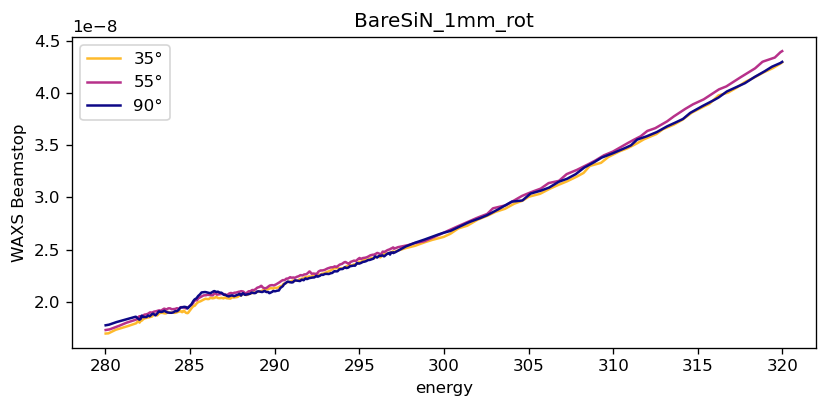

In [31]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DS.theta)))

for sample in nf_DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(nf_DS_carbon.theta.values):
        nf_DS['WAXS Beamstop'].sel(sample_name=sample, theta=theta_val, energy=slice(280,320)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

In [106]:
carbon_nf_DS.sample_name.values

array(['Y7BO_CBCN_rot', 'PM6_CBCN_rot', 'PM6-Y6_CB_rot',
       'PM6-Y6BO_CB_rot', 'PM6-Y7_CB_rot', 'PM6-Y7BO_CB_rot',
       'PM6-Y6_CBCN_rot', 'PM6-Y7_CBCN_rot', 'PM6-Y7BO_CBCN_rot',
       'Y6_CFCN_rot', 'Y6BO_CFCN_rot', 'Y7_CFCN_rot', 'Y7BO_CFCN_rot',
       'PM6_CFCN_rot', 'PM6-Y6_CF_rot', 'PM6-Y7BO_CF_rot',
       'PM6-Y6_CFCN_rot', 'PM6-Y6BO_CFCN_rot', 'PM6-Y7_CFCN_rot',
       'BareSiN_1mm_rot', 'BareSiN_1mm_rot_1', 'PM6-Y7_CF_rot',
       'PM6-Y7BO_CFCN_rot', 'PM6-Y6BO_CF_rot'], dtype=object)

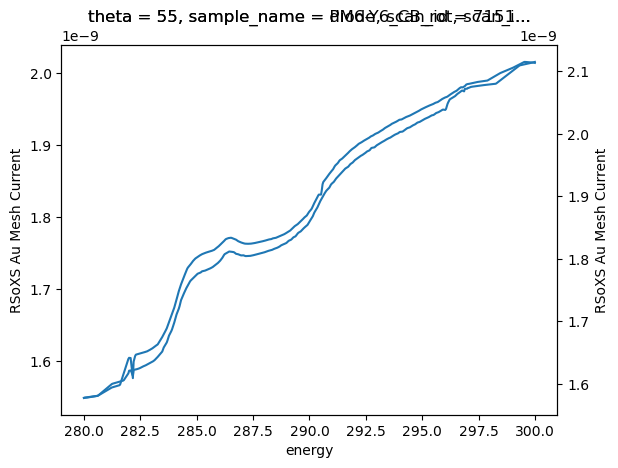

In [108]:
# Optional plot to compare Au Mesh Current locations

fig, ax = plt.subplots()
carbon_nf_DS['RSoXS Au Mesh Current'].sel(sample_name='PM6-Y6_CB_rot', theta=55, energy=slice(280,300)).plot.line(ax=ax)
diode_ax = ax.twinx()
carbon_diode_DS['RSoXS Au Mesh Current'].sel(sample_name='diode', theta=55, energy=slice(280,300)).plot.line(ax=diode_ax)
# diode_DS['WAXS Beamstop'].sel(sample_name='diode_grazing', theta=55).plot.line(ax=diode_ax)

plt.show()

### Create full nexafs dataset

In [92]:
# # TEY
# # Create nexafs dataset to export & apply/add double-norm-corrected data variable

# DS = xr.Dataset(attrs={'name': plan_of_interest})
# DS['raw_tey'] = nf_DS['RSoXS Sample Current']
# DS['sample_au_mesh'] = nf_DS['RSoXS Au Mesh Current']
# DS['calib_au_mesh'] = diode_DS['RSoXS Au Mesh Current'].squeeze('sample_name', drop=True)
# DS['calib_diode'] = diode_DS['WAXS Beamstop'].squeeze('sample_name', drop=True)
# DS['dnorm_tey'] = (DS['raw_tey'] / DS['sample_au_mesh']) * (DS['calib_au_mesh'] / DS['calib_diode'])

# DS

In [63]:
diode_DS_copy = nitrogen_diode_DS.sel(theta=[35,55,90])
diode_DS_copy

<xarray.Dataset>
Dimensions:                          (theta: 3, sample_name: 1, energy: 2000)
Coordinates:
  * theta                            (theta) int64 35 55 90
  * sample_name                      (sample_name) object 'diode'
    scan_id                          (theta) int64 71517 71518 71520
    sample_id                        (sample_name) <U5 'diode'
  * energy                           (energy) float64 370.0 370.0 ... 440.0
Data variables:
    NSLS-II Ring Current             (energy, theta, sample_name) float64 400...
    RSoXS Au Mesh Current            (energy, theta, sample_name) float64 3.4...
    RSoXS Sample Current             (energy, theta, sample_name) float64 -2....
    RSoXS Shutter Opening Time (ms)  (energy, theta, sample_name) float64 1e+...
    RSoXS Shutter Toggle             (energy, theta, sample_name) float64 1.0...
    RSoXS WAXS Shutter Counter       (energy, theta, sample_name) float64 3.5...
    SAXS Beamstop                    (energy, theta, sample_name) float64 4.0...
    WAXS Beamstop                    (energy, theta, sample_name) float64 1.9...
    energy_readback                  (energy, theta, sample_name) float64 370...
    RSoXS Shutter Toggle_thinned     (energy, theta, sample_name) float64 1.0...
Attributes:
    stream_name:  NSLS-II Ring Current_monitor

In [109]:
# TRMSN
# Create nexafs dataset to export & apply/add double-norm-corrected data variable

DS = xr.Dataset(attrs={'name': plan_of_interest})
DS['raw_trmsn'] = nf_DS['WAXS Beamstop']
DS['sample_au_mesh'] = nf_DS['RSoXS Au Mesh Current']
DS['calib_au_mesh'] = nf_DS['RSoXS Au Mesh Current'].sel(sample_name='BareSiN_1mm_rot')
DS['calib_diode'] = nf_DS['WAXS Beamstop'].sel(sample_name='BareSiN_1mm_rot')
# DS['calib_au_mesh'] = diode_DS_copy['RSoXS Au Mesh Current'].squeeze('sample_name', drop=True)
# DS['calib_diode'] = diode_DS_copy['WAXS Beamstop'].squeeze('sample_name', drop=True) 
DS['dnorm_trmsn'] = (DS['raw_trmsn'] / DS['sample_au_mesh']) * (DS['calib_au_mesh'] / DS['calib_diode'])

DS

<xarray.Dataset>
Dimensions:         (theta: 3, sample_name: 24, energy: 3000)
Coordinates:
  * theta           (theta) int64 35 55 90
  * sample_name     (sample_name) object 'Y7BO_CBCN_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id         (sample_name, theta) int64 71524 71525 71526 ... 71708 71709
    sample_id       (sample_name) <U12 'TRMSN29_rot' ... 'TRMSN45_rot'
  * energy          (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
Data variables:
    raw_trmsn       (energy, theta, sample_name) float64 8.262e-09 ... 1.15e-08
    sample_au_mesh  (energy, theta, sample_name) float64 1.247e-09 ... 3.352e-09
    calib_au_mesh   (energy, theta) float64 1.232e-09 1.243e-09 ... 3.071e-09
    calib_diode     (energy, theta) float64 9.348e-09 1.069e-08 ... 7.381e-08
    dnorm_trmsn     (energy, theta, sample_name) float64 0.8731 ... 0.1428
Attributes:
    name:     nexafs_carbon

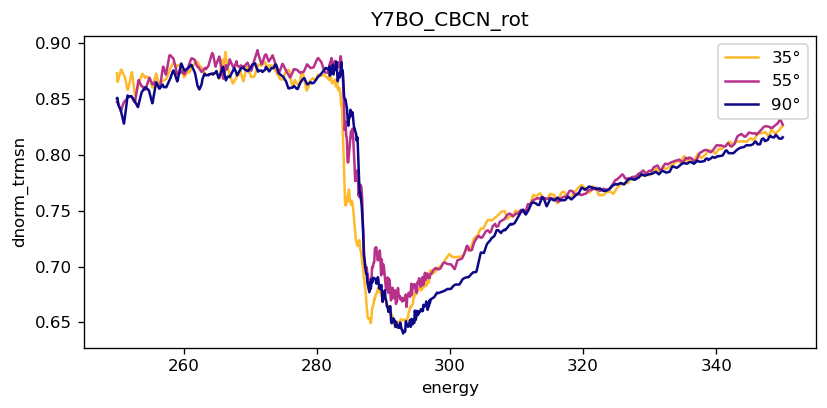

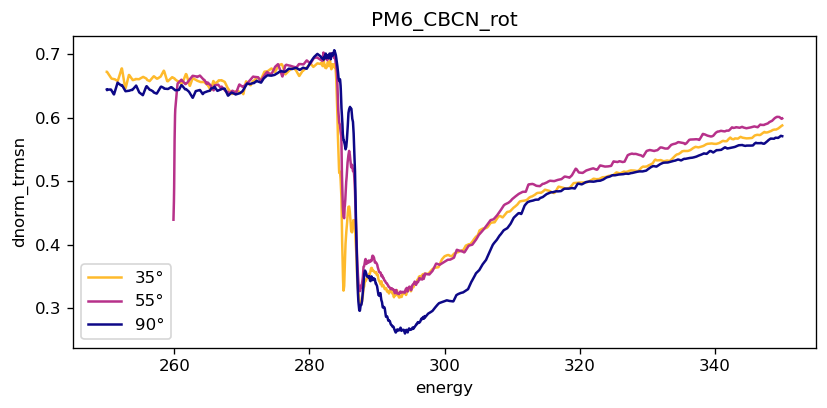

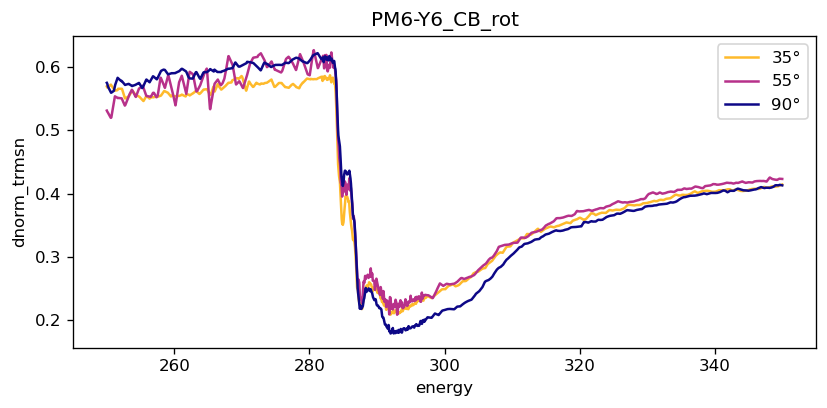

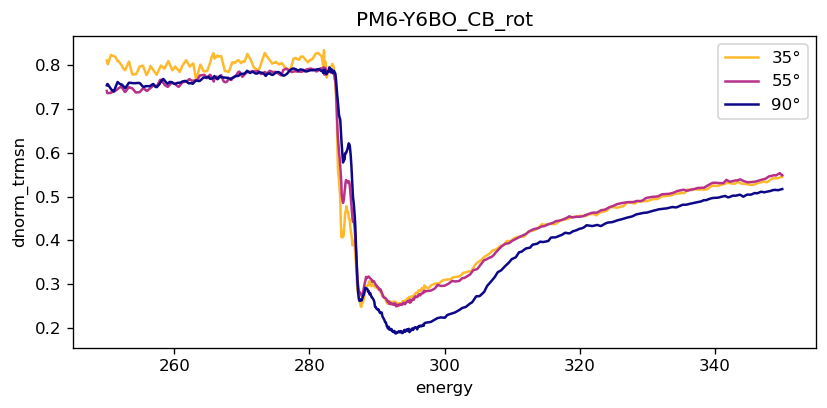

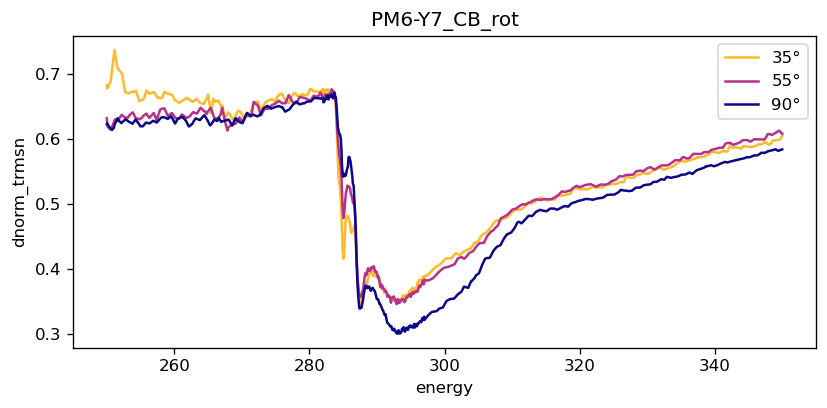

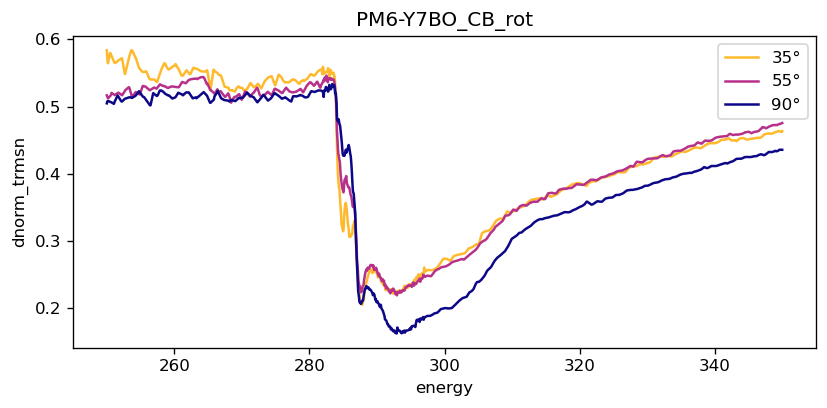

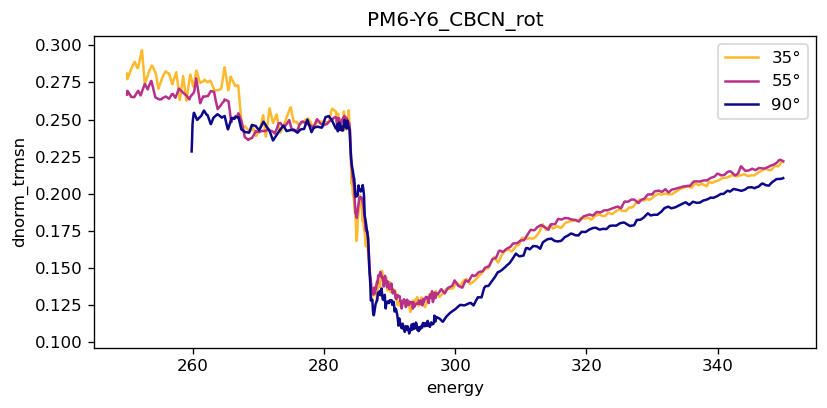

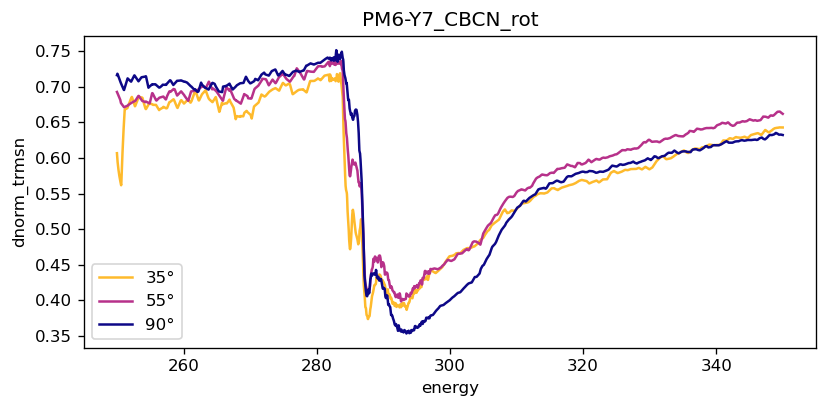

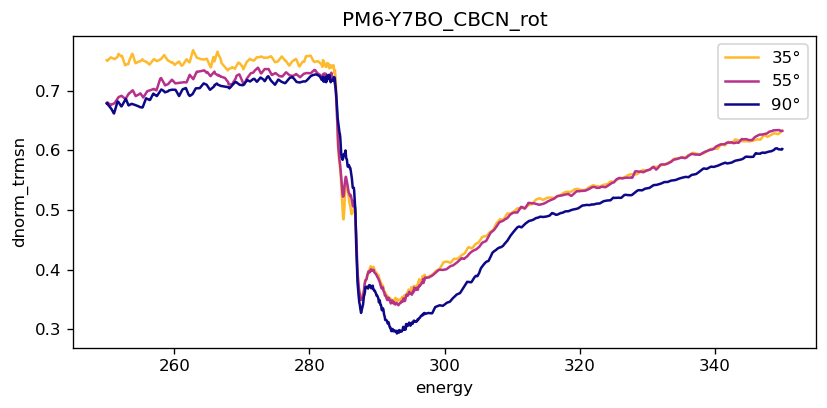

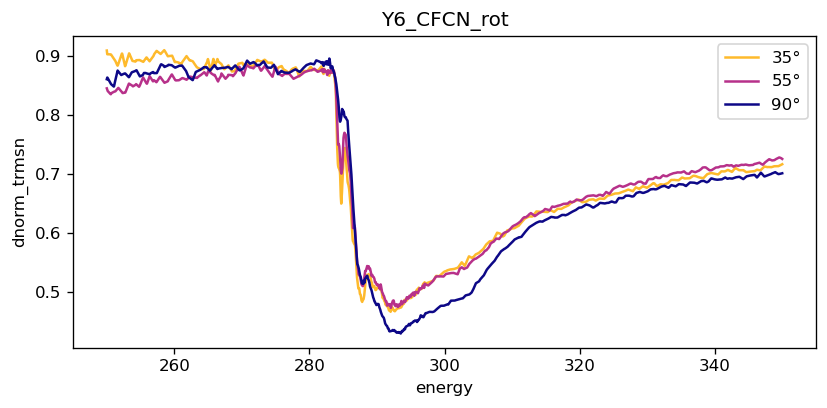

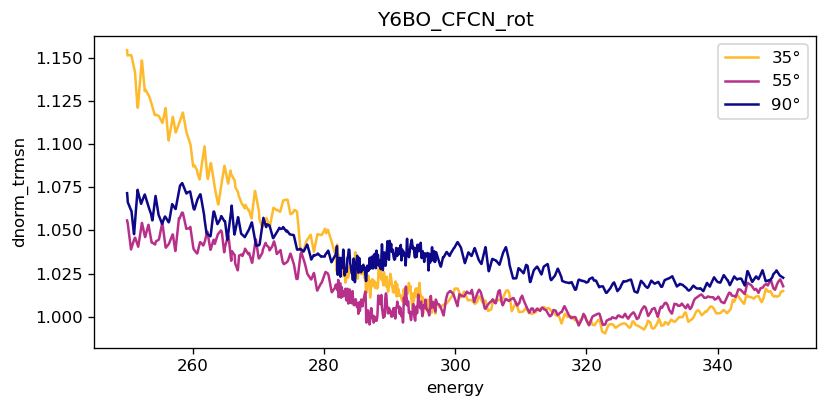

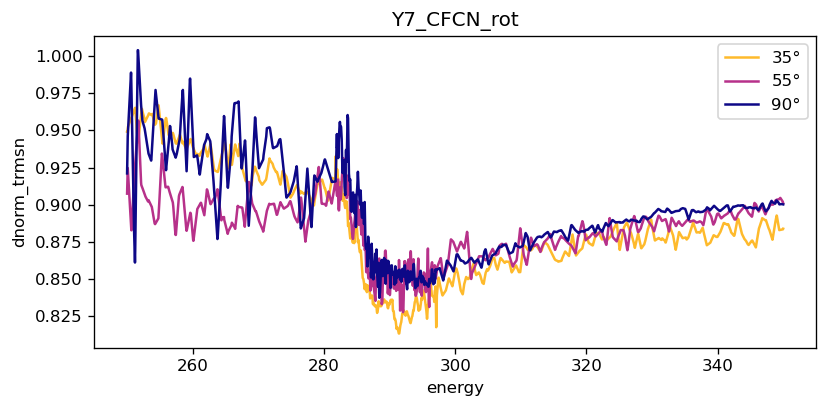

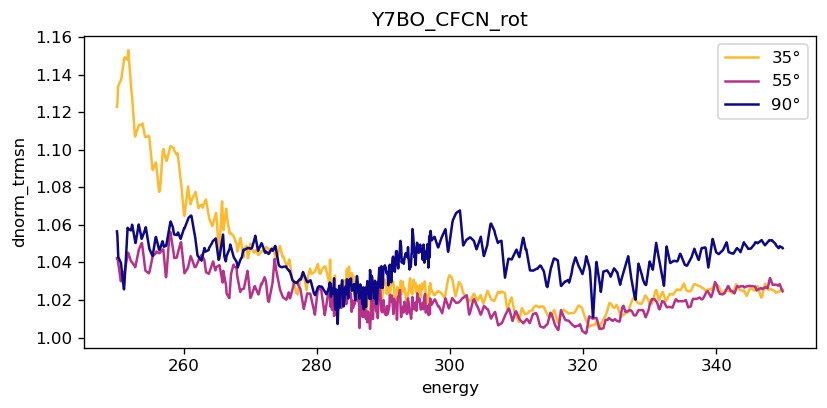

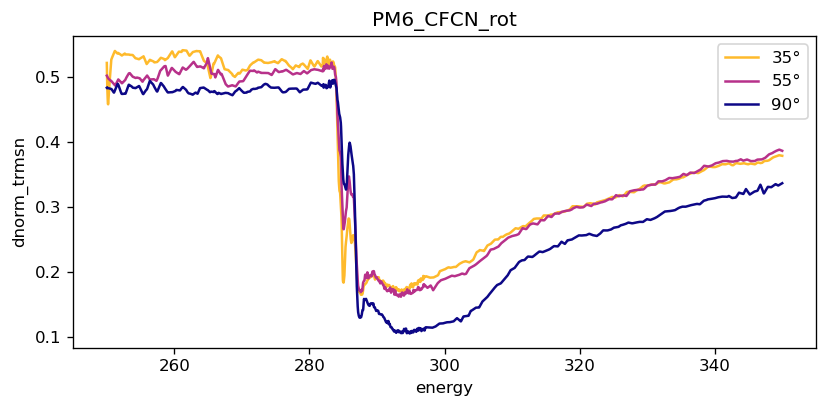

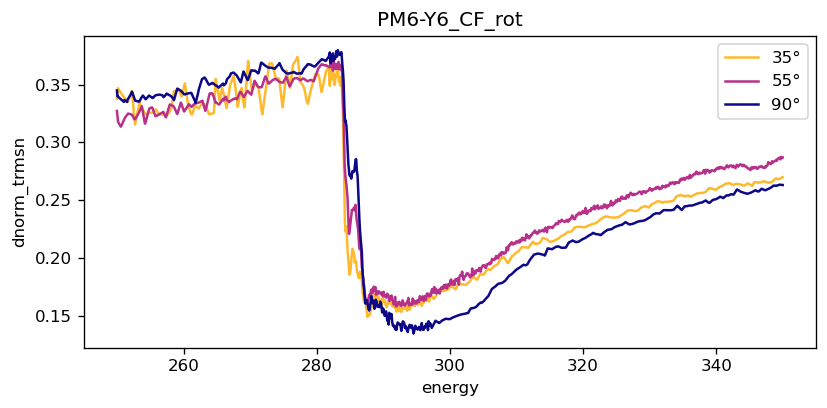

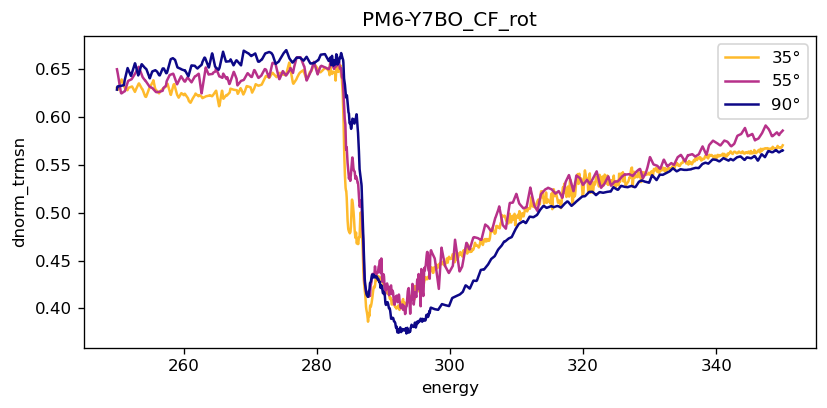

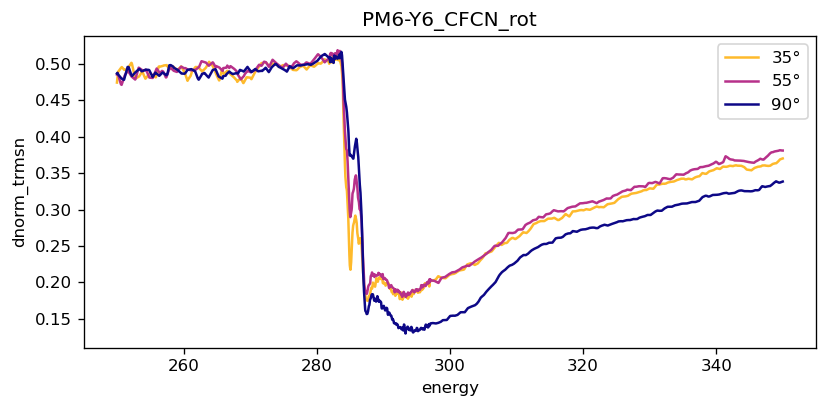

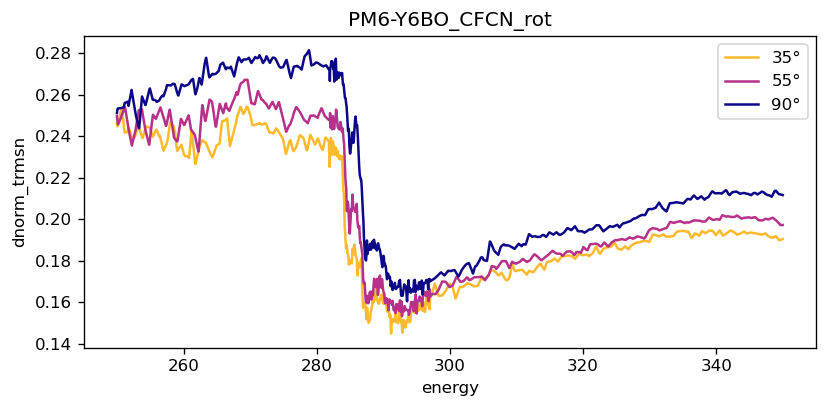

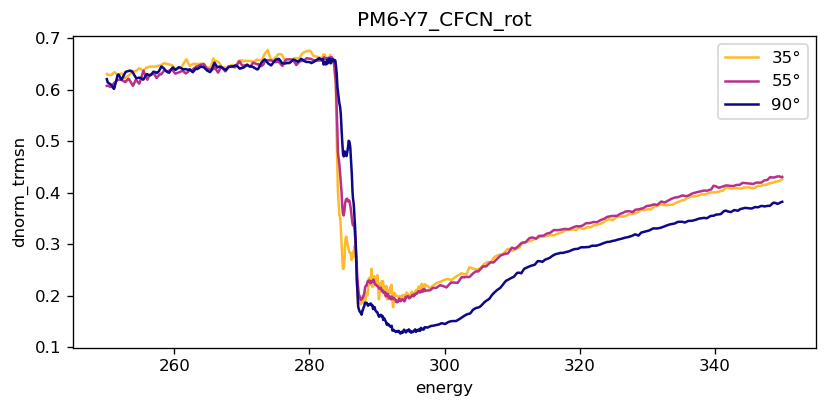

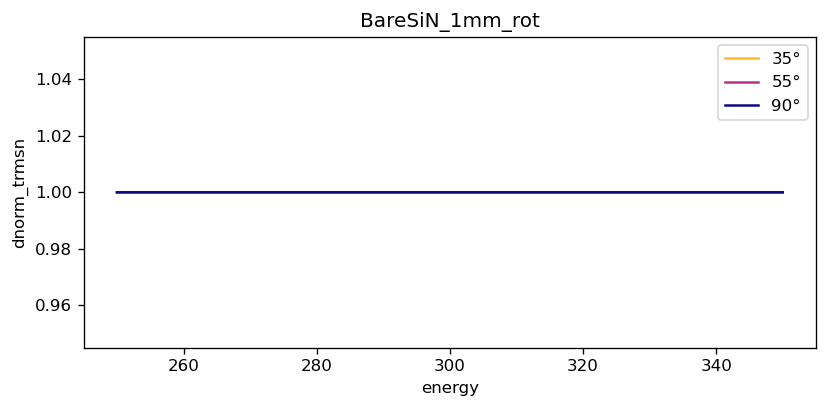

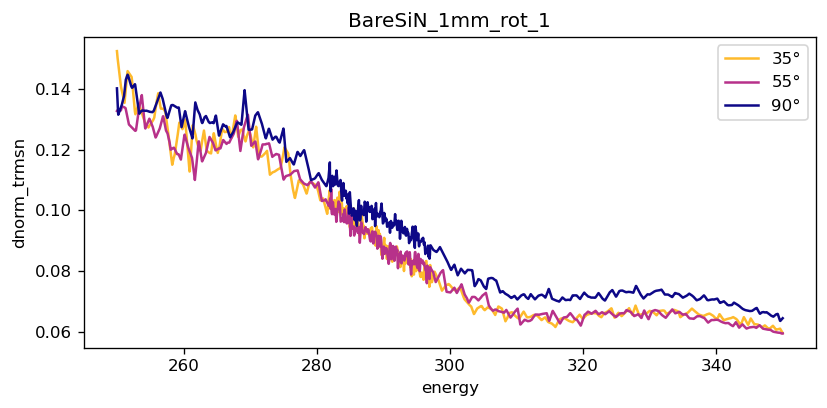

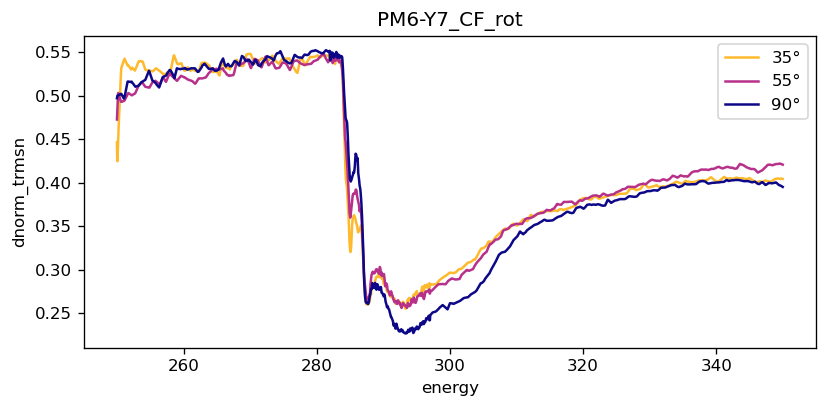

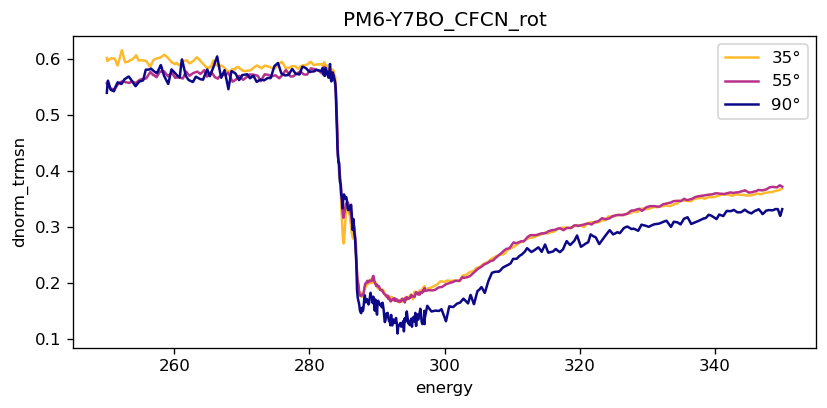

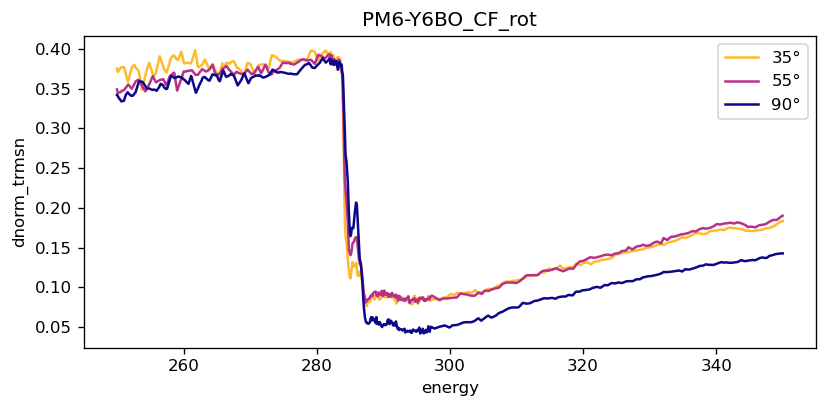

In [110]:
# Plot check

colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DS.theta)))

for sample in DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(DS.theta.values):
        DS['dnorm_trmsn'].sel(sample_name=sample, theta=theta_val, energy=slice(None,None)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

### Pre / post edge corrections

In [25]:
# Apply pre and post-edge normalizations (more involved right now...):

# data_var = 'dnorm_tey'
data_var = 'dnorm_trmsn'


# Set where to do pre/post edge corrections

pre_edge_energy_slice = slice(270, 280)  # carbon
post_edge_energy_slice = slice(320, 340)  # carbon

# pre_edge_energy_slice = slice(392, 397.4)  # nitrogen
# post_edge_energy_slice = slice(403, 404)  # nitrogen

# pre_edge_energy, post_edge_energy = [283, 310] # carbon
# pre_edge_energy, post_edge_energy = [395, 430] # nitrogen


# First generate list of corrected spectra
pre_corr_list = []
full_corr_list = []
for sample_name in DS.sample_name.values:
    for theta in DS.theta.values:
        # Linear fit for pre-edge region  
        mean_value = DS[data_var].sel(energy=pre_edge_energy_slice).mean()
        coefficients = np.polyfit(DS.energy.sel(energy=pre_edge_energy_slice), 
                                  DS[data_var].sel(energy=pre_edge_energy_slice, sample_name=sample_name, theta=theta), 
                                  1)
        y_fit = np.polyval(coefficients, DS.energy)
        
        # Subtract DA by either the y_fit or by the mean (horizontal line)
        pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - y_fit  # use slope y_fit
        # pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - mean_value  # use slope y_fit

        pre_corr_DA = pre_corr_DA.expand_dims({'sample_name': [pre_corr_DA.sample_name.data],
                                               'theta': [pre_corr_DA.theta.data]})
        pre_corr_DA = pre_corr_DA.assign_coords({'scan_id': ('theta', [pre_corr_DA.scan_id.data]),
                                                 'sample_id': ('sample_name', [pre_corr_DA.sample_id.data])})     
        
        pre_corr_list.append(pre_corr_DA)

        # Post edge
        post_edge_mean = pre_corr_DA.sel(energy=post_edge_energy_slice).mean(dim="energy")
        full_corr_DA = pre_corr_DA / float(post_edge_mean)        
        
        full_corr_list.append(full_corr_DA)

# Now reconstruct full dataarray and add to dataset created in prior cell
corr_names = ['pre_corr_trmsn', 'full_corr_trmsn']
# corr_names = ['pre_corr_tey', 'full_corr_tey']

for i, corr_list in enumerate([pre_corr_list, full_corr_list]):
# corr_names = ['pre_corr_trmsn']
# for i, corr_list in enumerate([pre_corr_list]):
    # First group by sample_name
    grouped_by_sample = {}
    for corr_DA in corr_list:
        sample_name = corr_DA.sample_name.values[0]
        if sample_name not in grouped_by_sample:
            grouped_by_sample[sample_name] = []
        grouped_by_sample[sample_name].append(corr_DA)

    # Concatenate by theta for each sample_name
    concat_by_theta = {}
    for sample_name, group in grouped_by_sample.items():
        concat_by_theta[sample_name] = xr.concat(group, dim="theta")

    # Finally, concatenate the result along the sample_name dimension
    DS[corr_names[i]] = xr.concat(list(concat_by_theta.values()), dim="sample_name")

# DS['full_corr_trmsn'] = DS['full_corr_trmsn'] - DS.sel(sample_name='BareSiN_1p5mm_rot')['full_corr_trmsn']
# DS['full_corr_trmsn'] = DS['full_corr_trmsn'] - DS.sel(sample_name='BareSiN_1mm_rot')['full_corr_trmsn']

DS

<xarray.Dataset>
Dimensions:          (energy: 3000, theta: 3, sample_name: 24)
Coordinates:
  * energy           (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
    sample_id        (sample_name) <U12 'TRMSN29_rot' ... 'TRMSN45_rot'
  * sample_name      (sample_name) object 'Y7BO_CBCN_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id          (sample_name, theta) int64 71524 71525 ... 71708 71709
  * theta            (theta) int64 35 55 90
    cos_sq_theta     (theta) float64 0.671 0.329 3.749e-33
Data variables:
    calib_au_mesh    (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    calib_diode      (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    dnorm_trmsn      (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    full_corr_trmsn  (sample_name, theta, energy) float64 dask.array<chunksize=(1, 1, 1500), meta=np.ndarray>
    pre_corr_trmsn   (sample_name, theta, energy) float64 dask.array<chunksize=(1, 1, 1500), meta=np.ndarray>
    raw_trmsn        (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    sample_au_mesh   (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
Attributes:
    name:     nexafs_carbon

  0%|          | 0/1 [00:00<?, ?it/s]

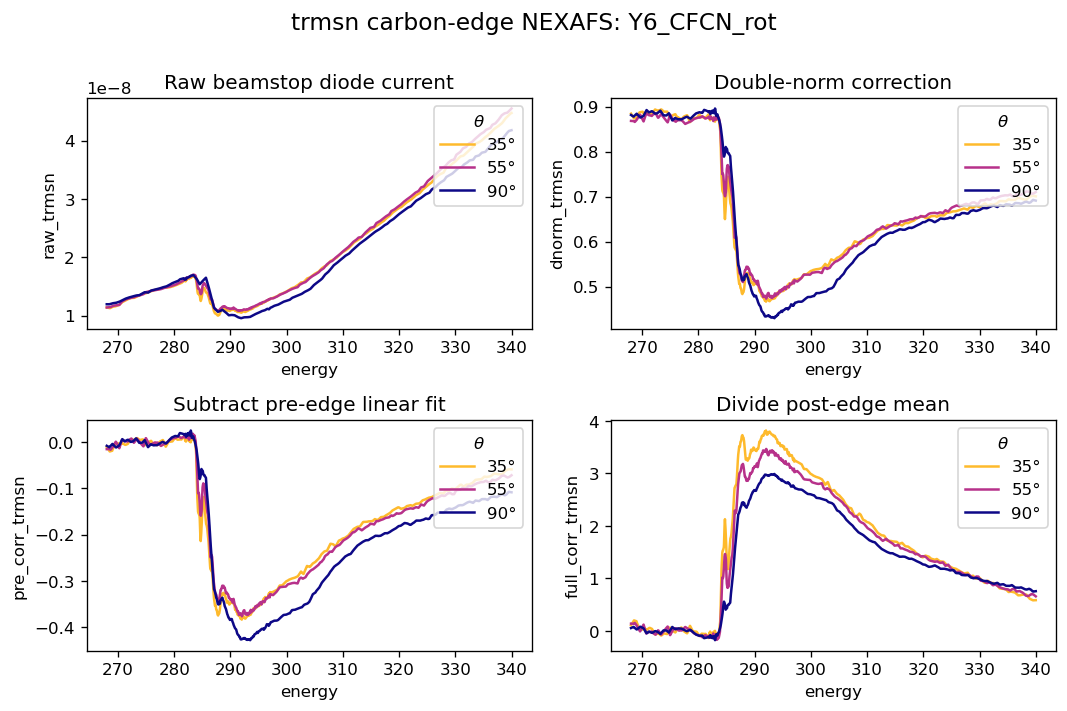

In [27]:
# for nexafs_type in ['pey', 'tey', 'fy_csi']:
for nexafs_type in ['trmsn']:
    # print(nexafs_type)
    # DS = loaded_DS.copy()
    edge = 'carbon'
    # nexafs_type = 'fy_csi'

    # energy_min = 387  # nitrogen
    # energy_max = 419.5  # nitrogen

    energy_min = 268
    energy_max = 340

    energy_slice = slice(energy_min, energy_max)
    # energy_slice = slice(None, None)

    # energy_slice = slice(250,350) # carbon
    # energy_slice = slice(370, 440) # nitrogen
    # energy_slice = slice(396, 405) # nitrogen

    # Create the colormap
    colors = plt.cm.plasma_r(np.linspace(0.15, 1, len(DS.theta)))
    # colors = plt.cm.plasma(np.linspace(0, 0.85, len(DS.theta)))


    # for sample_name in tqdm(DS.sample_name.values):
    for sample_name in tqdm(['Y6_CFCN_rot']):
        fig, axs = plt.subplots(2, 2)
        fig.set(size_inches=(9, 6), dpi=120, tight_layout=True)
        fig.suptitle(f'{nexafs_type} {edge}-edge NEXAFS: {sample_name}', fontsize=14)
        # fig.suptitle(f'Transmission {edge}-edge NEXAFS: {sample_name}', fontsize=14)
        # fig.suptitle(f'TEY {edge}-edge NEXAFS: {sample_name}', fontsize=14)

        for i, theta_val in enumerate(DS.theta.values):
            sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
            sliced_DS[f'raw_{nexafs_type}'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS[f'dnorm_{nexafs_type}'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS[f'pre_corr_{nexafs_type}'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS[f'full_corr_{nexafs_type}'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
            # ((sliced_DS[f'full_corr_{nexafs_type}'] / float(DS[f'full_corr_{nexafs_type}'].sel(
            #                                           sample_name=sample_name, theta=theta_val, energy=slice(402,404)).mean('energy')))
            #  .plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°'))

        axs[0,0].set(title='Raw beamstop diode current')
        axs[0,1].set(title='Double-norm correction')
        axs[1,0].set(title='Subtract pre-edge linear fit')
        axs[1,1].set(title='Divide post-edge mean')
        # axs[1,1].set(title='Divide post-edge mean & subtract SiN spectra')

        # Optionally, add legends
        axs[0,0].legend(title=r"$\theta$", loc='upper right')
        axs[0,1].legend(title=r"$\theta$", loc='upper right')
        axs[1,0].legend(title=r"$\theta$", loc='upper right')
        axs[1,1].legend(title=r"$\theta$", loc='upper right')

        plt.show()
        # fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_nexafs_all', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
        # fig.savefig(outPath.joinpath(f'nexafs_plots/nf_chamber_{nexafs_type}_{edge}_nexafs_all', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
        plt.close('all')

### Save zarr

In [113]:
# DS.to_zarr(zarrsPath.joinpath(f'TEY_{DS.name}.zarr'), mode='w')
DS.to_zarr(zarrsPath.joinpath(f'TRMSN_{DS.name}_3angle.zarr'), mode='w')

## Load nexafs zarr

In [4]:
sorted([f.name for f in zarrsPath.glob('*')])

['.ipynb_checkpoints',
 'PEY_nexafs_carbon.zarr',
 'PEY_nexafs_nitrogen.zarr',
 'TEY_nexafs_carbon.zarr',
 'TEY_nexafs_nitrogen.zarr',
 'TRMSN_nexafs_carbon_3angle.zarr',
 'TRMSN_nexafs_carbon_day1.zarr',
 'TRMSN_nexafs_nitrogen_3angle.zarr',
 'TRMSN_nexafs_nitrogen_day1.zarr',
 'cartesian_rsoxs_carbon_ncs',
 'cartesian_rsoxs_carbon_rechunked-v2.zarr',
 'cartesian_rsoxs_nitrogen_ncs',
 'cartesian_rsoxs_nitrogen_rechunked-v1.zarr',
 'material_optical_constants.zarr',
 'polar_rsoxs_carbon_ncs',
 'polar_rsoxs_carbon_rechunked-v2.zarr',
 'polar_rsoxs_nitrogen_ncs',
 'polar_rsoxs_nitrogen_rechunked-v1.zarr']

In [5]:
plan_of_interest = 'nexafs_carbon'
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TEY_{plan_of_interest}.zarr'))
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TRMSN_{plan_of_interest}_day1.zarr'))
loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TRMSN_{plan_of_interest}_3angle.zarr'))
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'PEY_{plan_of_interest}.zarr'))

# Compute any dask coordiantes
for coord_name, coord_data in loaded_DS.coords.items():
    if isinstance(coord_data.data, da.Array):
        loaded_DS.coords[coord_name] = coord_data.compute()

DS = loaded_DS.copy().assign_coords({'cos_sq_theta': ('theta', ((np.cos(np.deg2rad(loaded_DS.theta)))**2).data)})
DS

<xarray.Dataset>
Dimensions:          (energy: 3000, theta: 3, sample_name: 24)
Coordinates:
  * energy           (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
    sample_id        (sample_name) <U12 'TRMSN29_rot' ... 'TRMSN45_rot'
  * sample_name      (sample_name) object 'Y7BO_CBCN_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id          (sample_name, theta) int64 71524 71525 ... 71708 71709
  * theta            (theta) int64 35 55 90
    cos_sq_theta     (theta) float64 0.671 0.329 3.749e-33
Data variables:
    calib_au_mesh    (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    calib_diode      (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    dnorm_trmsn      (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    full_corr_trmsn  (sample_name, theta, energy) float64 dask.array<chunksize=(12, 2, 1500), meta=np.ndarray>
    pre_corr_trmsn   (sample_name, theta, energy) float64 dask.array<chunksize=(12, 2, 1500), meta=np.ndarray>
    raw_trmsn        (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    sample_au_mesh   (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
Attributes:
    name:     nexafs_carbon

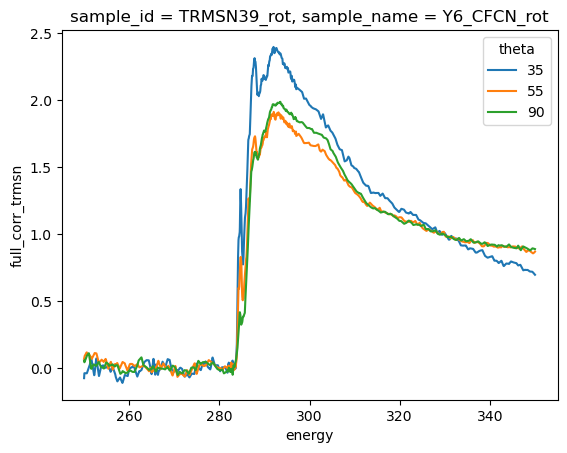

In [6]:
DS.sel(sample_name='Y6_CFCN_rot')['full_corr_trmsn'].plot(hue='theta')
plt.show()

### Plot normalized NEXAFS

trmsn


  0%|          | 0/24 [00:00<?, ?it/s]

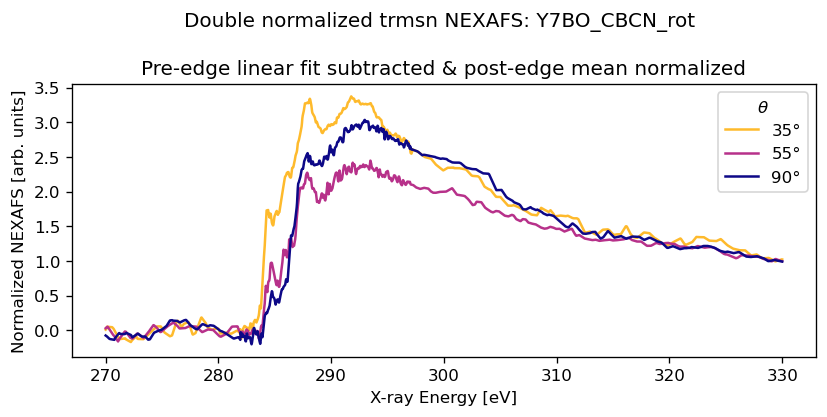

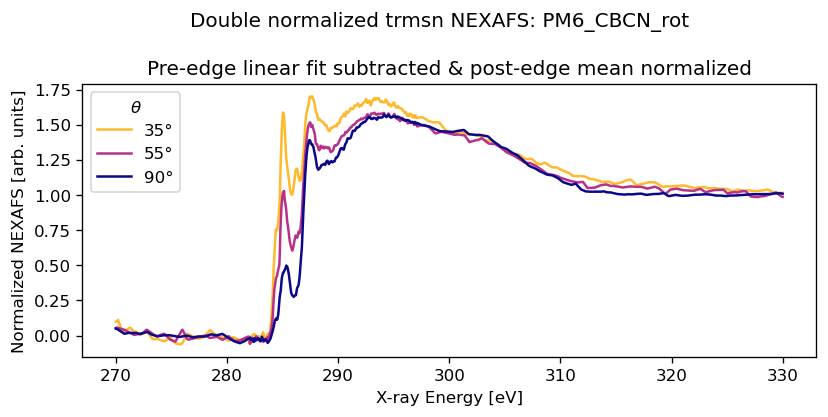

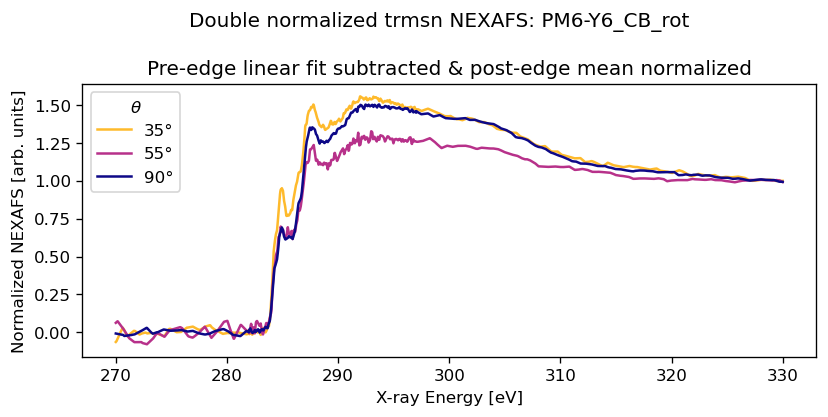

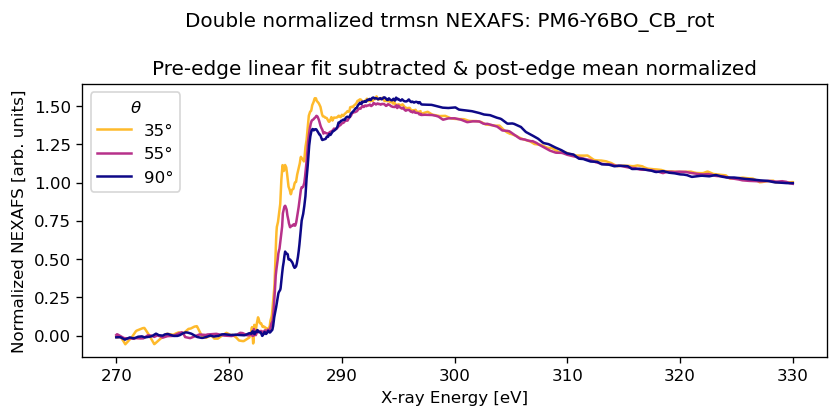

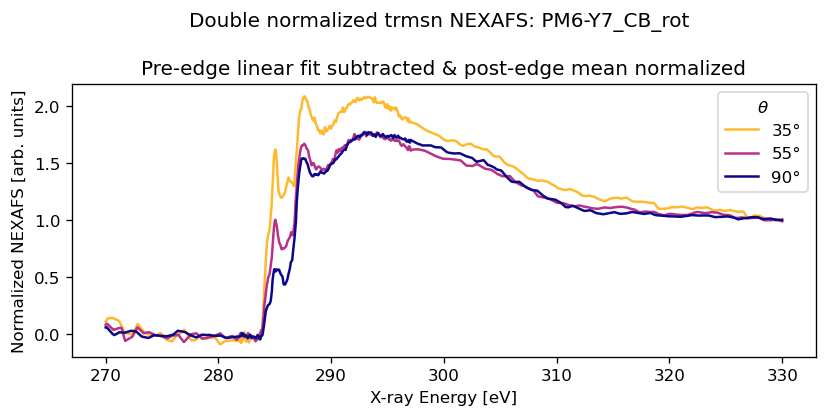

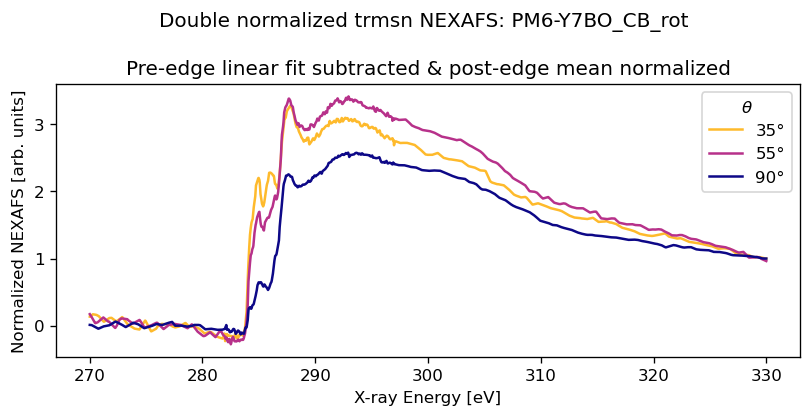

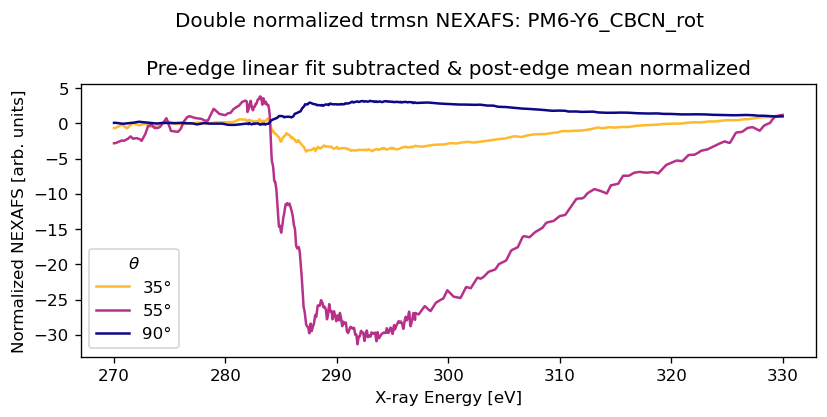

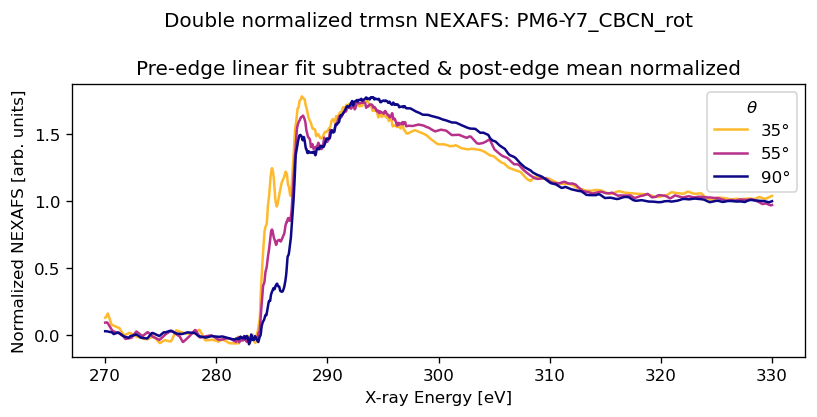

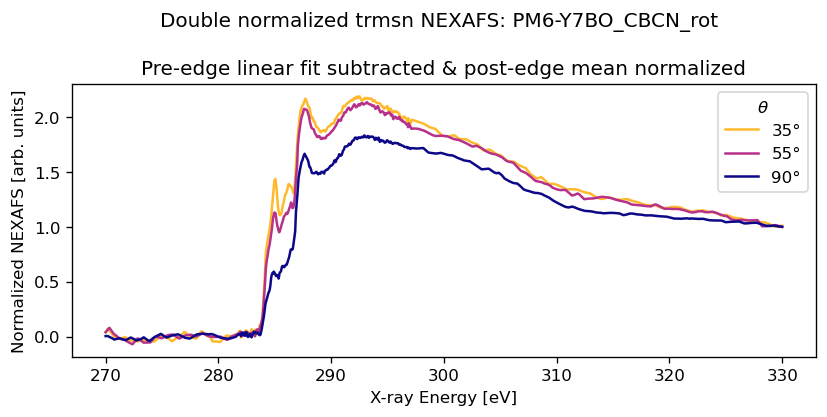

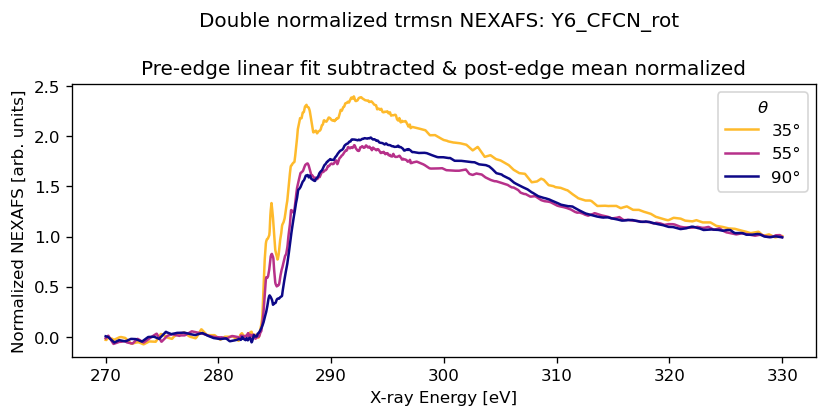

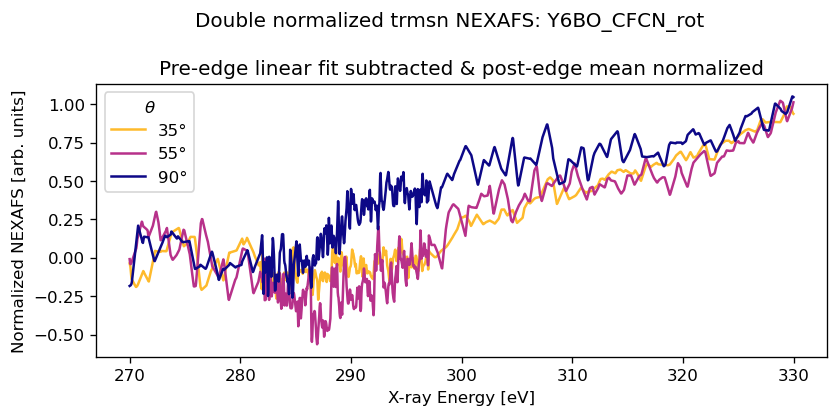

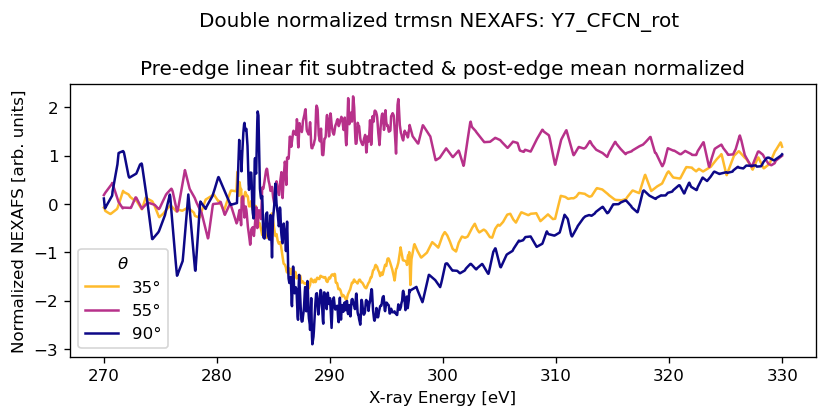

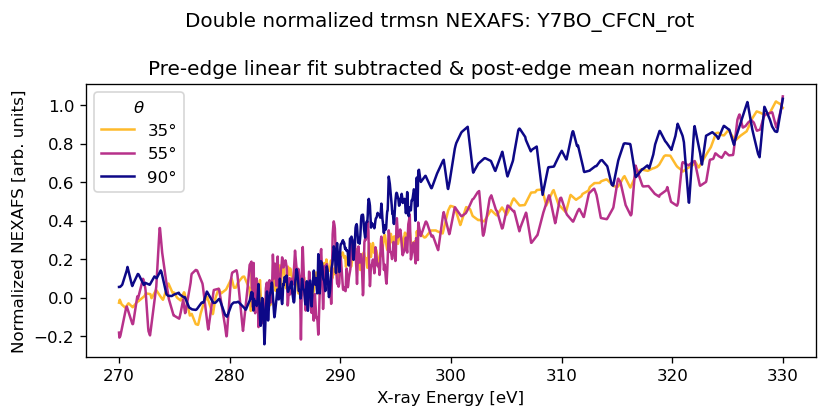

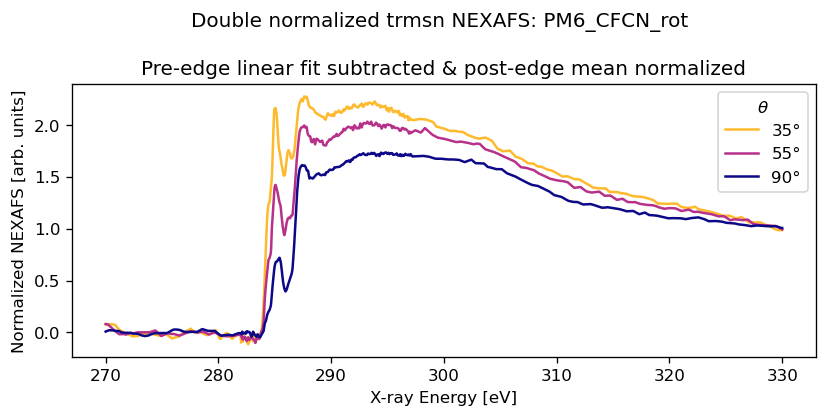

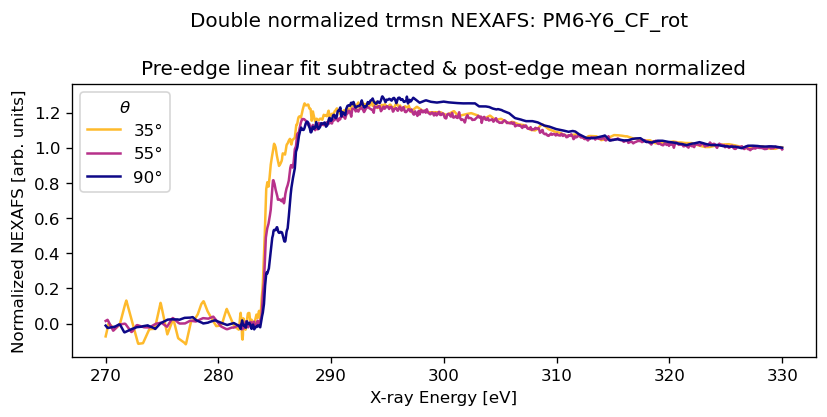

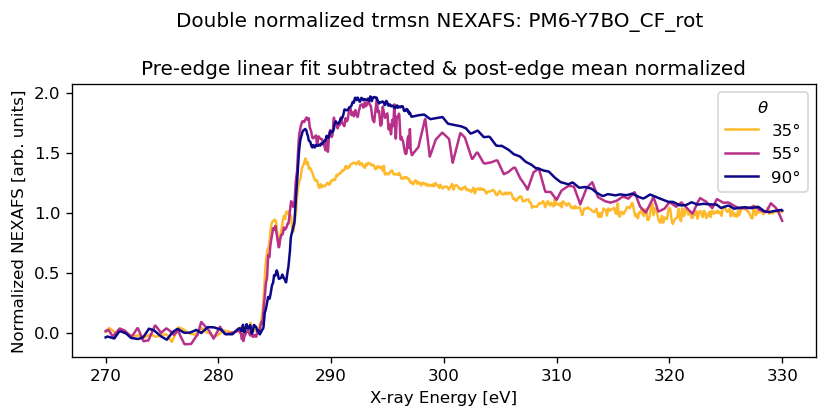

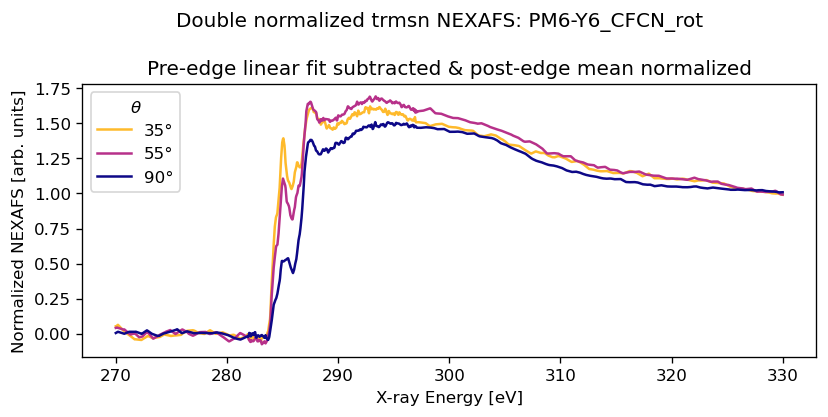

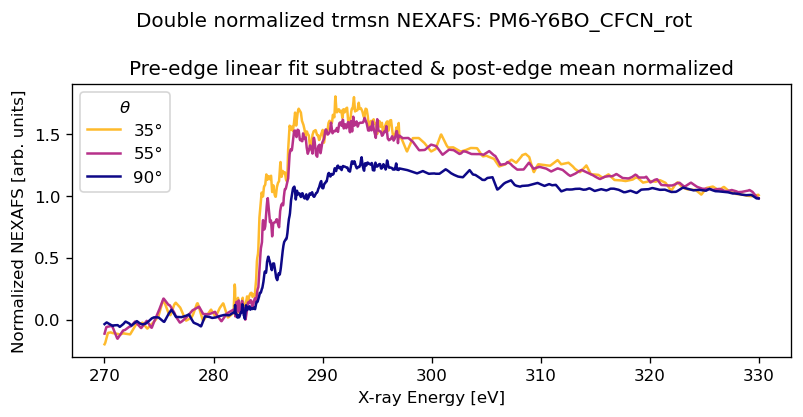

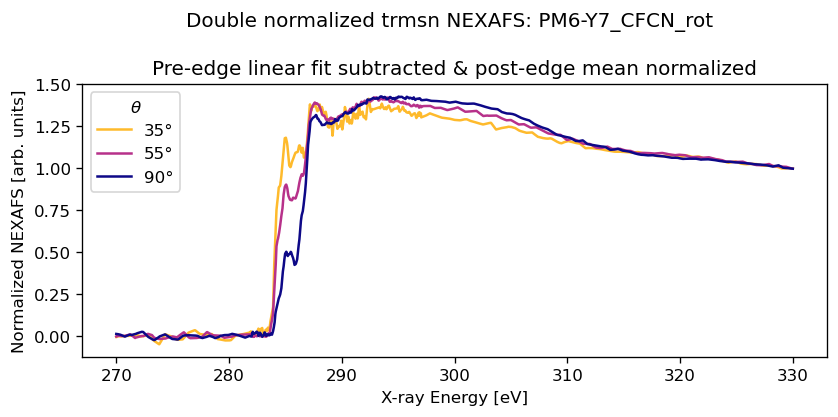

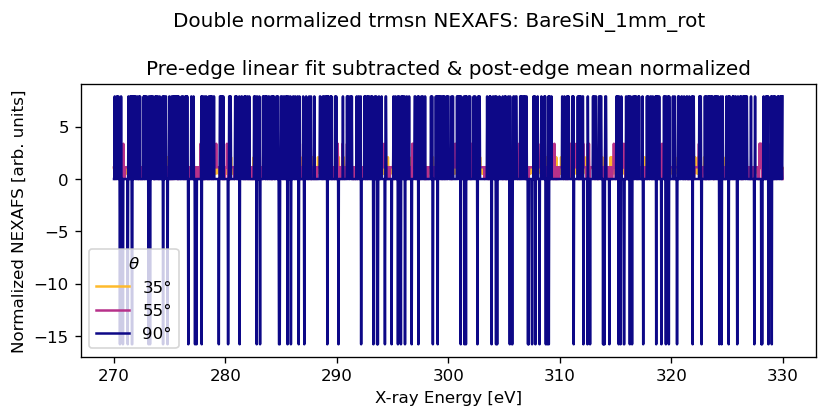

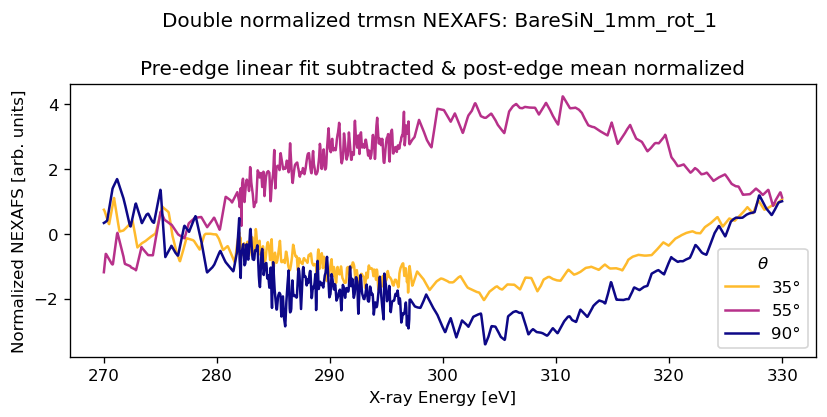

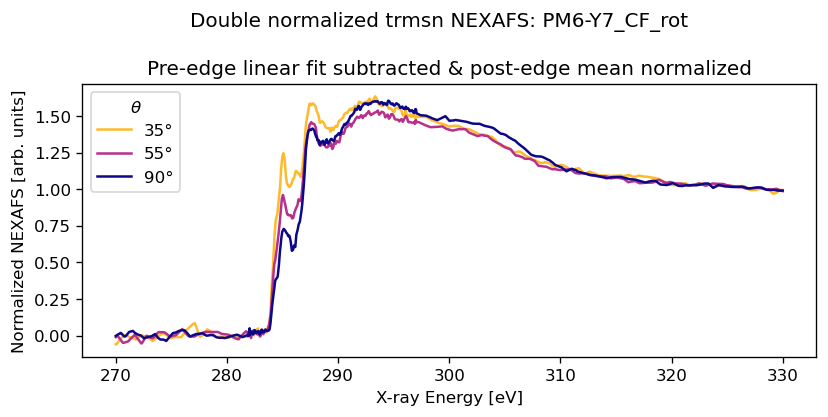

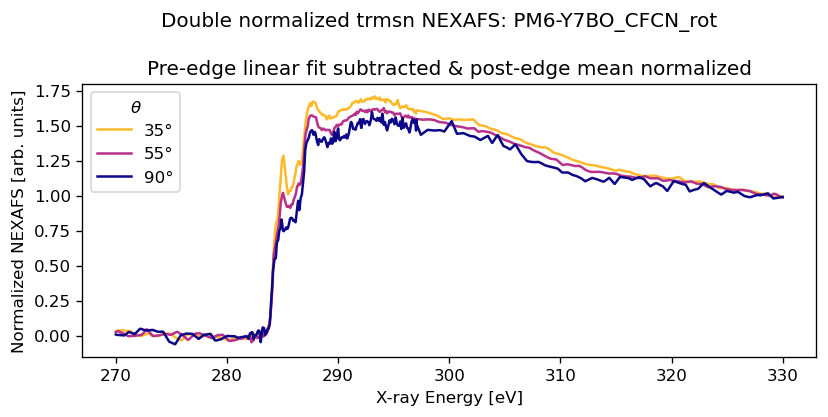

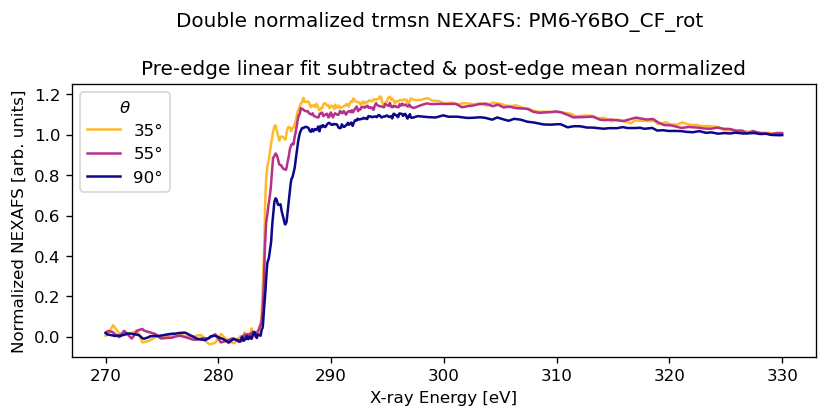

In [8]:
for nexafs_type in ['trmsn']:
# for nexafs_type in ['pey', 'tey', 'fy_csi']:
    print(nexafs_type)
    # nexafs_type = 'fy_csi'
    edge = 'carbon'

    energy_min = 270
    energy_max = 330
    # energy_min = 396  # nitrogen
    # energy_max = 405  # nitrogen
    energy_slice = slice(energy_min, energy_max)

    colors = plt.cm.plasma_r(np.linspace(0.15,1,len(DS.theta)))
    # colors = plt.cm.plasma(np.linspace(0,0.85,len(DS.theta)))

    for sample_name in tqdm(DS.sample_name.values):
        fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
        for i, theta_val in enumerate(DS.theta.values):
            (DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name, theta=theta_val, energy=energy_slice)
                                           .plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°'))

        # fig.suptitle(f'Double normalized TEY NEXAFS: {sample_name}', x=0.53)
        # fig.suptitle(f'Double normalized transmission NEXAFS: {sample_name}', x=0.53)
        fig.suptitle(f'Double normalized {nexafs_type} NEXAFS: {sample_name}', x=0.53)
        ax.set(title='Pre-edge linear fit subtracted & post-edge mean normalized', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
        ax.legend(title=r'$\theta$')
        # fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_nexafs_full_corr', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
        # fig.savefig(outPath.joinpath(f'nexafs_plots/nf_chamber_{nexafs_type}_{edge}_nexafs_full_corr', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
        plt.show()
        plt.close('all')

#### Optionally run molecular tilt fit

In [35]:
DS

<xarray.Dataset>
Dimensions:          (energy: 3000, theta: 3, sample_name: 24)
Coordinates:
  * energy           (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
    sample_id        (sample_name) <U12 'TRMSN29_rot' ... 'TRMSN45_rot'
  * sample_name      (sample_name) object 'Y7BO_CBCN_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id          (sample_name, theta) int64 71524 71525 ... 71708 71709
  * theta            (theta) int64 35 55 90
    cos_sq_theta     (theta) float64 0.671 0.329 3.749e-33
Data variables:
    calib_au_mesh    (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    calib_diode      (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    dnorm_trmsn      (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    full_corr_trmsn  (sample_name, theta, energy) float64 dask.array<chunksize=(1, 1, 1500), meta=np.ndarray>
    pre_corr_trmsn   (sample_name, theta, energy) float64 dask.array<chunksize=(1, 1, 1500), meta=np.ndarray>
    raw_trmsn        (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    sample_au_mesh   (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
Attributes:
    name:     nexafs_carbon

In [36]:
pi_peak_areas

array([26.94536865,  1.76977213, -0.06967123])

trmsn


  0%|          | 0/1 [00:00<?, ?it/s]

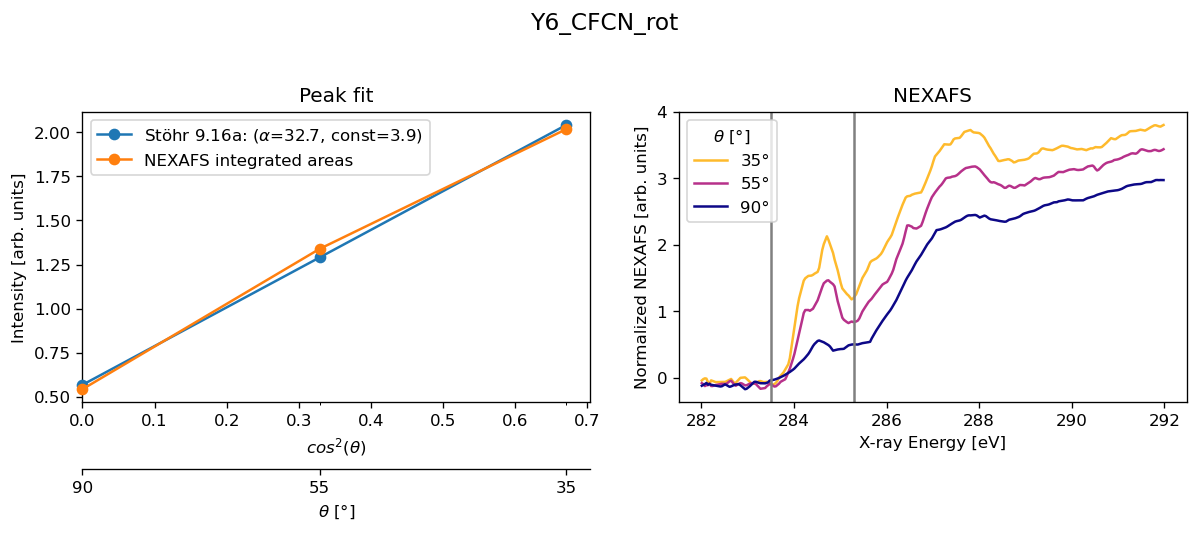

In [38]:
# Run Stöhr 9.16a tilt fit on energy region of NEXAFS

# for nexafs_type in ['pey', 'tey', 'fy_csi']:
for nexafs_type in ['trmsn']:
    print(nexafs_type)
    # nexafs_type = 'fy_csi'
    edge = 'carbon'

    # carbon
    energy_min = 283.5
    energy_max = 285.3
    # energy_max = 285.5
    
    # energy_min = 284
    # energy_max = 286

    # nitrogen
    # energy_min = 397.8
    # energy_max = 399.2

    # energy_min = 399.2
    # energy_max = 400.4

    # energy_min = 400.4
    # energy_max = 402

    # sample_name = 'PM6_3000_dSiN_R'
    # for sample_name in tqdm(DS.sample_name.values):
    for sample_name in tqdm(['Y6_CFCN_rot']):
        nf_DA = DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name)

        pi_peak_areas = nf.int_area(energy_min, energy_max, nf_DA)

        bnds = [(0, 90), (0, 20)]
        res = optimize.differential_evolution(
            nf.mse_line_tilt, bounds=bnds, args=(pi_peak_areas, nf_DA.theta.values), tol=1e-6)

        alpha, const = res.x

        # Plot intensities from Stöhr 9.16a (scaled with fitted constant) as line
        # along with measured pi_peak_areas, x-axis is cos_sq_theta:
        fig, axs = plt.subplots(ncols=2, figsize=(10,4.5), dpi=120, tight_layout=True)
        fig.suptitle(str(nf_DA.sample_name.values), y=1.03, fontsize=14)
        axs[0].plot(nf_DA.cos_sq_theta.values[:], const * nf.i_nexafs(alpha, nf_DA.theta.values[:]),
                marker='o', label=f'Stöhr 9.16a: ($\\alpha$={np.round(alpha,2)}, const={np.round(const,2)})',
                clip_on=False, zorder=3)
        axs[0].plot(nf_DA.cos_sq_theta.values[:], pi_peak_areas[:], marker='o',
                label=f'NEXAFS integrated areas', clip_on=False, zorder=4)
        axs[0].set(title='Peak fit', xlabel=r'$cos^2(\theta)$', ylabel='Intensity [arb. units]')
        axs[0].set_xticks(nf_DA.cos_sq_theta.values, minor=True)
        axs[0].set_xlim(left=0)
        axs[0].legend()

        # Add secondary axis showing theta values:
        def forward(x):
            return np.arccos(np.sqrt(x)) * 180 / np.pi

        def inverse(x):
            return np.cos(x * np.pi / 180)**2

        ax2 = axs[0].secondary_xaxis(-0.23, functions=(forward, inverse))
        ax2.set(xlabel=r'$\theta$ [$\degree$]')
        ax2.set_xticks(nf_DA.theta.values)


        colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DA.theta)))
        for i, theta_val in enumerate(nf_DA.theta.values):
            (nf_DA.sel(theta=theta_val, energy=slice(282, 292))
            # (nf_DA.sel(theta=theta_val, energy=slice(396, 405))
                   .plot.line(ax=axs[1], color=colors[i], label=f'{int(theta_val)}°'))

        axs[1].axvline(energy_min, color='grey')
        axs[1].axvline(energy_max, color='grey')
        axs[1].set(title='NEXAFS', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
        axs[1].legend(title=r'$\theta$ [$\degree$]', loc='upper left')

        # fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_tilt_fit', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
        # fig.savefig(outPath.joinpath(f'nexafs_plots/nf_chamber_{nexafs_type}_{edge}_tilt_fit', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)

        plt.show()
        plt.close('all')

### Calculate optical constants & binary contrasts

#### Define functions & chemical formulas 

In [11]:
# Define function to calculate binary contrast
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

# Add chemical formulas as coordinate along 'sample_name' dimension
# Define necessary formula stoichiometries
Y6_formula = 'C82H86F4N8O2S5'
Y7_formula = 'C82H86Cl4N8O2S5'
PM6_formula = 'C68H76F2O2S8'
PM7_formula = 'C68H76Cl2O2S8'

# Make dictionary of sample_name keys and formula values
chemical_formulas = {}
for sample_name in DS.sample_name.values:
    if 'Y6_' in sample_name or 'A1_' in sample_name or 'A2_' in sample_name or 'A3_' in sample_name:
        chemical_formulas[sample_name] = Y6_formula
    elif 'Y7_' in sample_name:
        chemical_formulas[sample_name] = Y7_formula
    elif 'PM6_' in sample_name:
        chemical_formulas[sample_name] = PM6_formula
    elif 'PM7_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula
    elif 'PM6-Y6_' in sample_name:
        chemical_formulas[sample_name] = Y6_formula+PM6_formula
    elif 'PM6-Y7_' in sample_name:
        chemical_formulas[sample_name] = PM6_formula+Y7_formula
    elif 'PM7-Y6_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula+Y6_formula
    elif 'PM7-Y7_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula+Y7_formula
    elif 'BareS' in sample_name:
        chemical_formulas[sample_name] = 'SiN'
    else: 
        chemical_formulas[sample_name] = 'AlO'

# Assign coordinate
# DS = DS.assign_coords({'chemical_formula': ('sample_name', names2formula(DS.sample_name.values))})
DS = DS.assign_coords({'chemical_formula': ('sample_name', list(map(lambda x: chemical_formulas[x], DS.sample_name.values)))})

DS

<xarray.Dataset>
Dimensions:           (energy: 3000, theta: 3, sample_name: 24)
Coordinates:
  * energy            (energy) float64 250.0 250.0 250.1 ... 349.9 350.0 350.0
    sample_id         (sample_name) <U12 'TRMSN29_rot' ... 'TRMSN45_rot'
  * sample_name       (sample_name) object 'Y7BO_CBCN_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id           (sample_name, theta) int64 71524 71525 ... 71708 71709
  * theta             (theta) int64 35 55 90
    cos_sq_theta      (theta) float64 0.671 0.329 3.749e-33
    chemical_formula  (sample_name) <U15 'AlO' 'C68H76F2O2S8' ... 'AlO' 'AlO'
Data variables:
    calib_au_mesh     (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    calib_diode       (energy, theta) float64 dask.array<chunksize=(3000, 3), meta=np.ndarray>
    dnorm_trmsn       (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    full_corr_trmsn   (sample_name, theta, energy) float64 dask.array<chunksize=(12, 2, 1500), meta=np.ndarray>
    pre_corr_trmsn    (sample_name, theta, energy) float64 dask.array<chunksize=(12, 2, 1500), meta=np.ndarray>
    raw_trmsn         (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
    sample_au_mesh    (energy, theta, sample_name) float64 dask.array<chunksize=(1500, 2, 12), meta=np.ndarray>
Attributes:
    name:     nexafs_carbon

#### Generate optical constants dataset

In [270]:
# Calculate optical constants via kkcalc
# Also calculate vacuum contrast
nexafs_type = 'tey'

x_min = 525
x_max = 555

n_list = []
for sample_name in tqdm(DS.sample_name.values):
    nf_DA = DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name)
    chemical_formula = str(nf_DA.chemical_formula.values)
    n = nf.run_kkcalc_a(nf_DA, x_min=x_min, x_max=x_max, chemical_formula=chemical_formula, density=1.1)
    n = n.expand_dims({'sample_name':[sample_name]})
    n_list.append(n)
    
n_DS = xr.concat(n_list, dim='sample_name')
n_DS = n_DS.swap_dims({'cos_sq_theta':'theta'})
n_DS['vacuum_contrast'] = binary_contrast(n_DS)
n_DS

  0%|          | 0/11 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:          (energy: 1520, theta: 5, sample_name: 11)
Coordinates:
  * energy           (energy) float64 10.0 10.16 10.33 ... 1e+05 1e+05 5e+05
    cos_sq_theta     (theta) float64 0.883 0.75 0.329 0.117 3.749e-33
  * sample_name      (sample_name) object 'Y6_Si' 'Y7_Si' ... 'A2_Si' 'A3_Si'
  * theta            (theta) int64 20 30 55 70 90
Data variables:
    delta            (sample_name, theta, energy) float64 -0.171 ... 9.634e-10
    beta             (sample_name, theta, energy) float64 0.294 ... 9.207e-16
    vacuum_contrast  (energy, sample_name, theta) float64 1.157e+03 ... 5.8e+04
Attributes:
    name:     optical constants

#### Plot optical constants and vacuum contrasts

  0%|          | 0/11 [00:00<?, ?it/s]

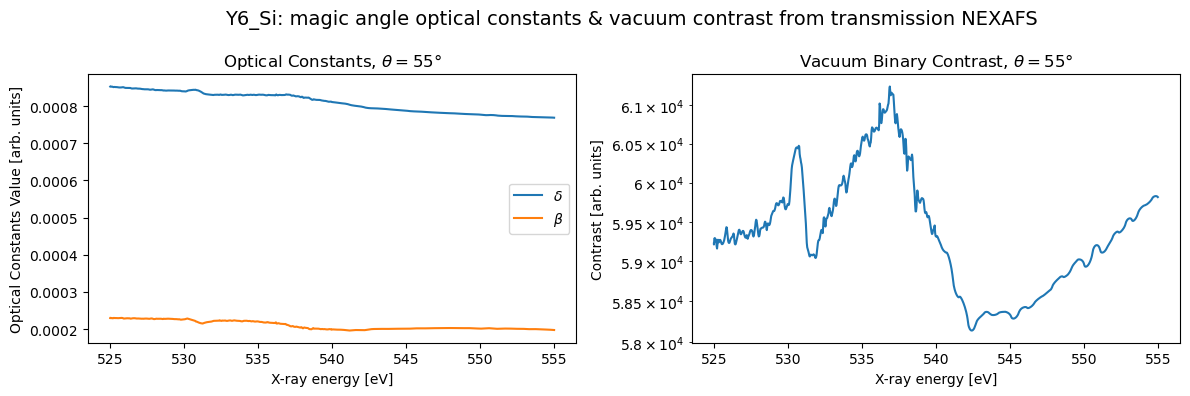

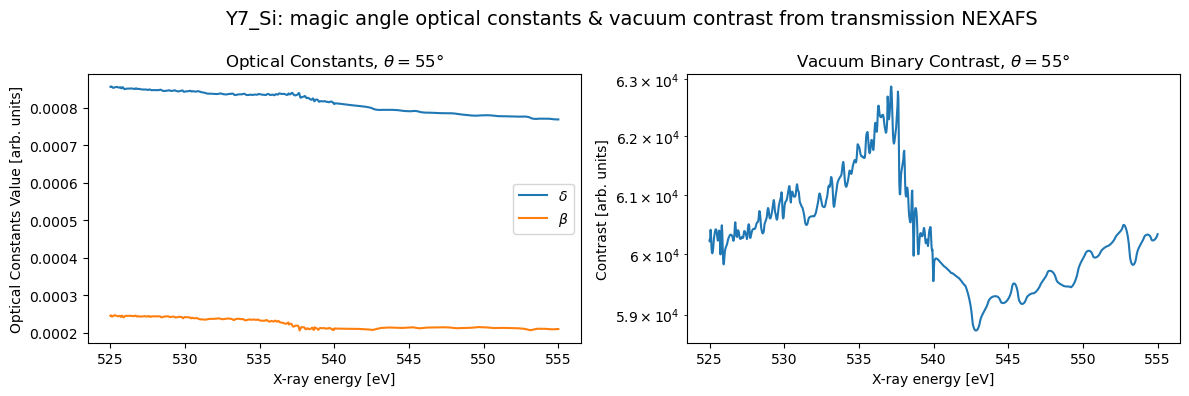

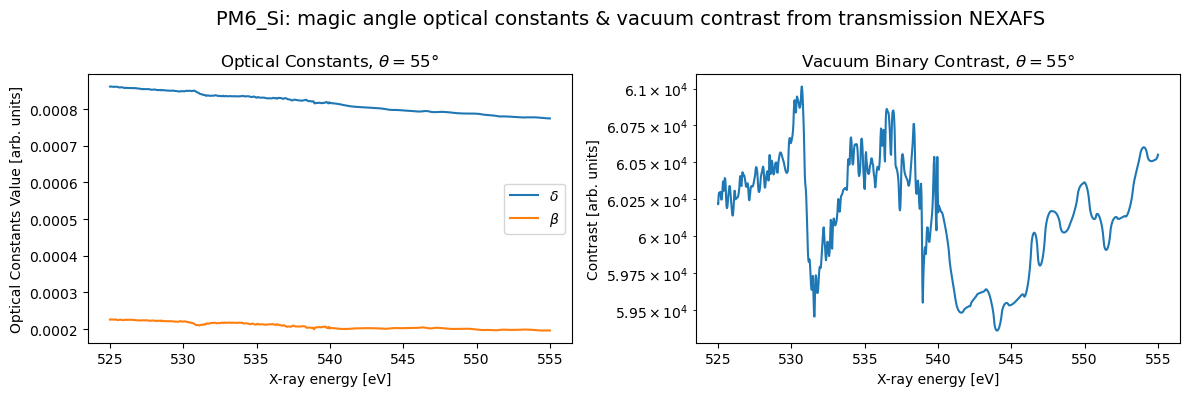

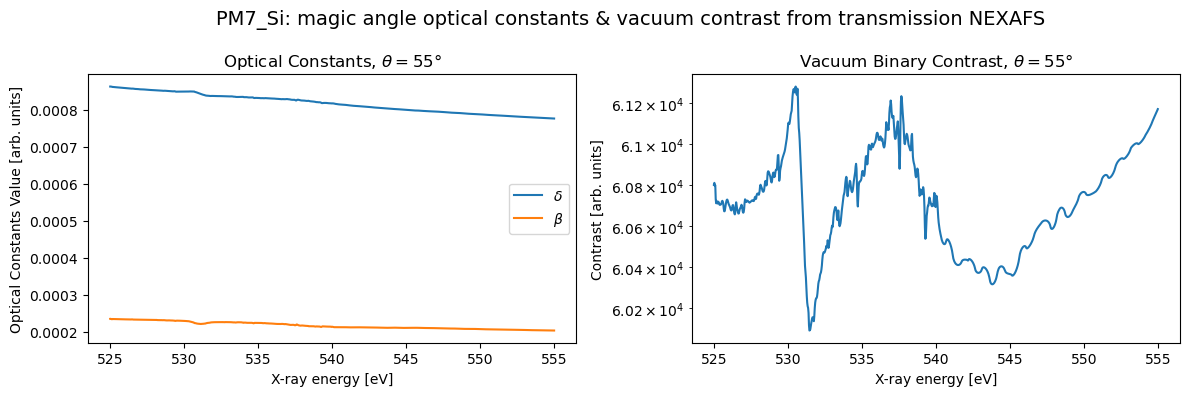

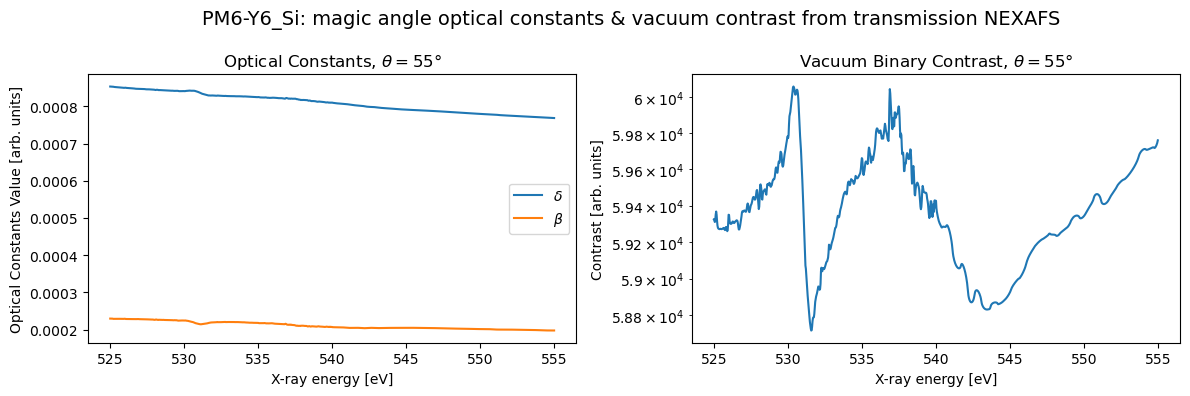

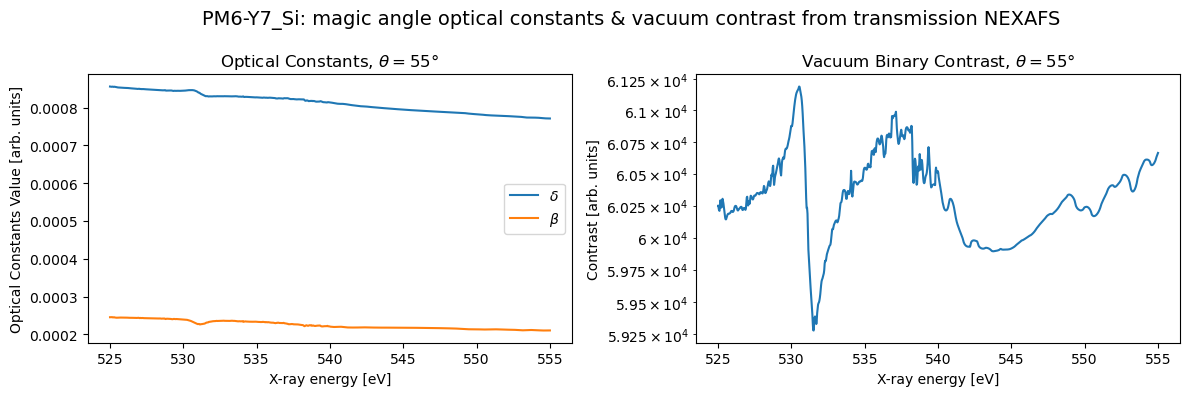

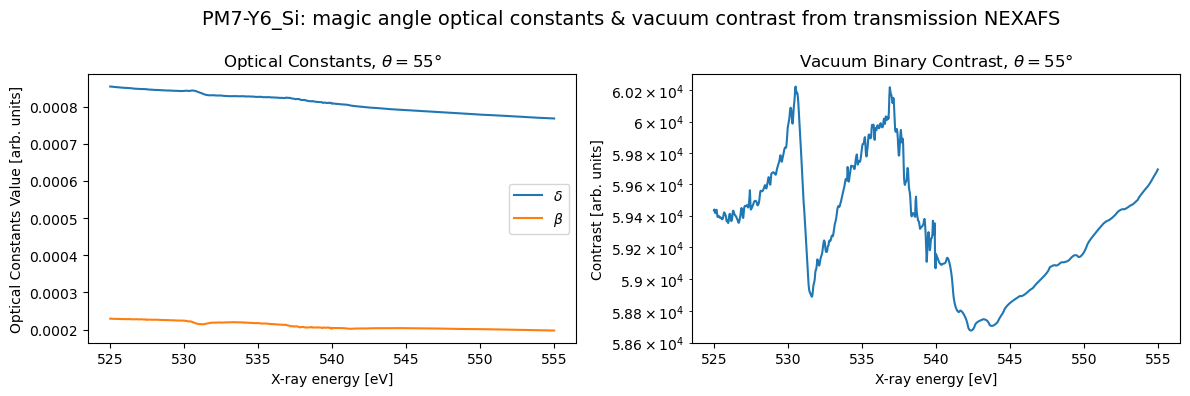

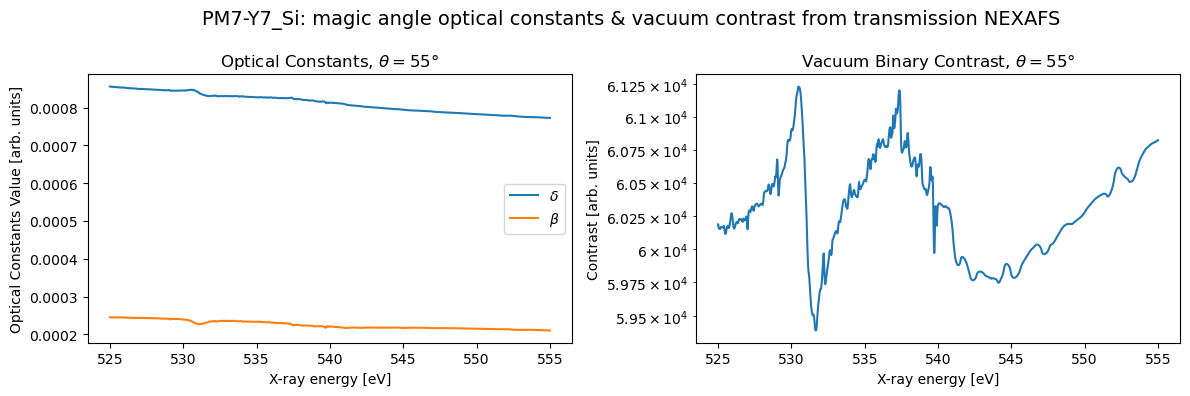

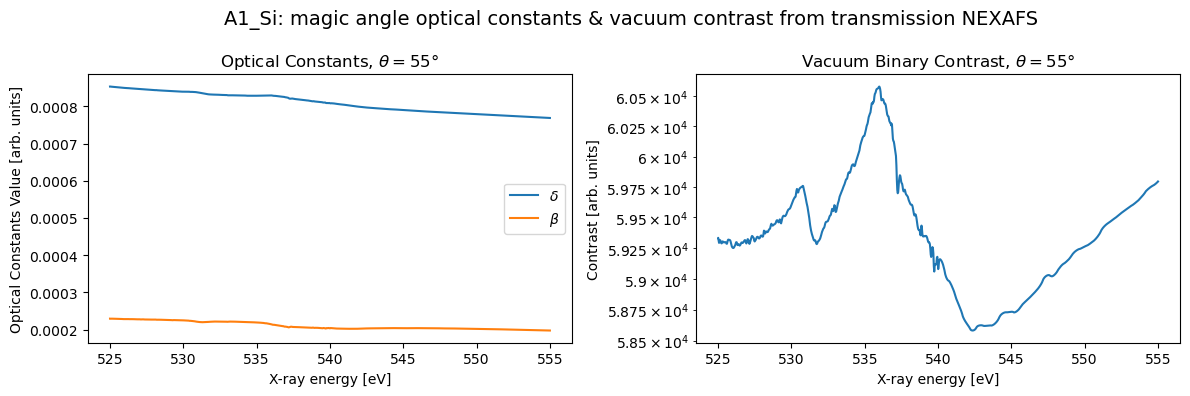

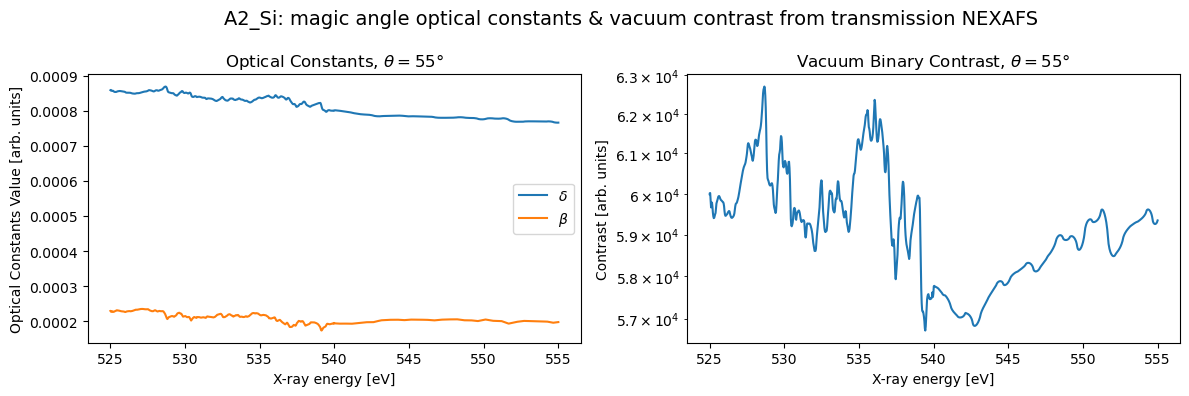

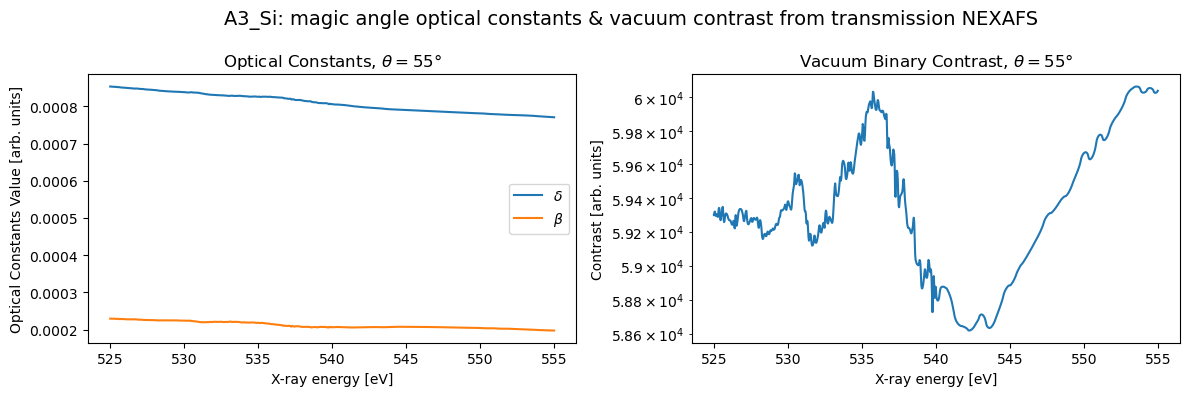

In [272]:
# Plot optical constants and vacuum contrast for each sample 

# Set energy bounds and theta
nexafs_type = 'tey'
energy_min = 520
energy_max = 560
energy_slice = slice(energy_min, energy_max) # carbon
theta = 55
# theta = 90

# Plotting loop
for sample_name in tqdm(n_DS.sample_name.values):
    fig, axs = plt.subplots(ncols=2, figsize=(12,4), tight_layout=True)
    fig.suptitle(f'{sample_name}: magic angle optical constants & vacuum contrast from transmission NEXAFS', fontsize=14, x=0.53)
    n_DS['delta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\delta$')
    n_DS['beta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\beta$')
    n_DS['vacuum_contrast'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[1], yscale='log')
    axs[0].legend()
    axs[0].set(title=r'Optical Constants, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Optical Constants Value [arb. units]')
    axs[1].set(title=r'Vacuum Binary Contrast, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Contrast [arb. units]')
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_oxygen_magic_constants', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.show()
    plt.close('all')

#### Plot binary contrasts

  0%|          | 0/4 [00:00<?, ?it/s]

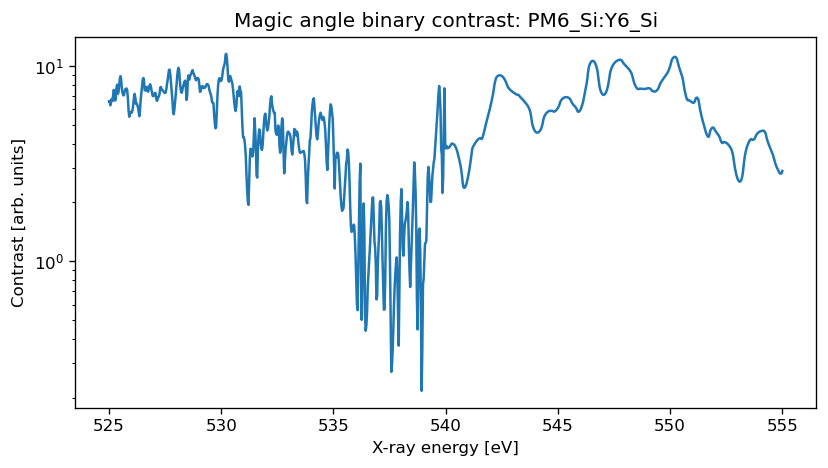

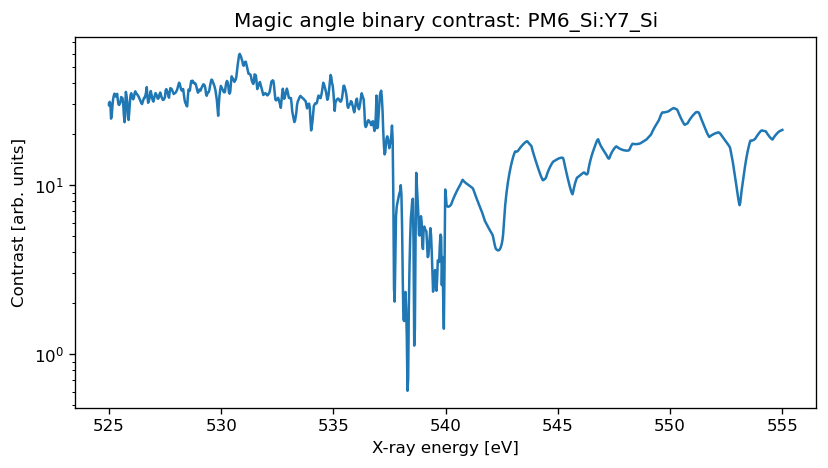

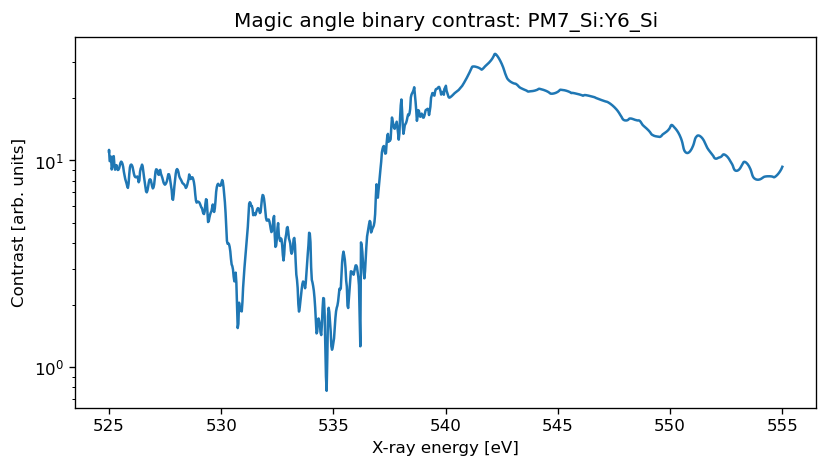

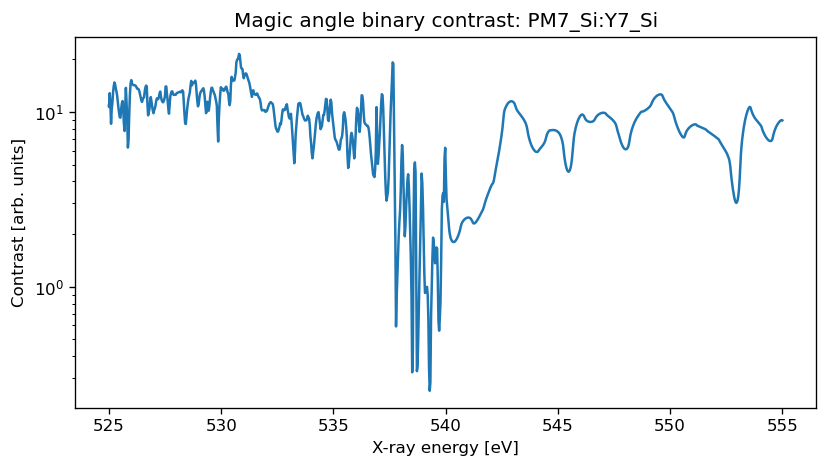

In [273]:
# Define sample_name pairs to plot binary contrast for
# pairs = [
#     ('PM6_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM6_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM7_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_2000_dSiN_R') 
# ]

pairs = [
    ('PM6_Si', 'Y6_Si'),
    ('PM6_Si', 'Y7_Si'),    
    ('PM7_Si', 'Y6_Si'),
    ('PM7_Si', 'Y7_Si'),    
]

# Set energy bounds and select theta
nexafs_type = 'tey_oxygen'
energy_min = 525
energy_max = 555
energy_slice = slice(energy_min, energy_max)
theta = 55

# Plotting loop
for pair in tqdm(pairs):
    fig, ax = plt.subplots(figsize=(7,4), dpi=120, tight_layout=True)
    (binary_contrast(n_DS.sel(sample_name=pair[0]), n_DS.sel(sample_name=pair[1]))
     .sel(theta=theta, energy=energy_slice)
     .plot.line(ax=ax, yscale='log'))
    ax.set(title=f'Magic angle binary contrast: {pair[0]}:{pair[1]}', ylabel='Contrast [arb. units]', xlabel='X-ray energy [eV]')
    plt.show()
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_magic_binary_contrasts', f'{pair[0]}-{pair[1]}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.close('all')

This dielectric function, pretty though it is, still isn't sufficient even to describe the unaxial function of the measured NEXAFS. That is because the extraordinary part of the dielectric function could only be measured by the NEXAFS measurement at $\theta=0$°. There is no experimental geometry that allows $\theta=0$°, so it must be extrapolated.

Intensity should be linear with $cos^2\theta$, so we will fit the nexafs xarray to it. The below xr.polyfit function creates a linear fit function <em>at every energy</em> in the nexafs curve.

# Other code:

In [ ]:
# # Peter D's kkcalc function for numpy arrays:
# from kkcalc import data
# from kkcalc import kk
# import numpy as np

# def calculate_deltabeta(spectra_e, spectra_abs, chemform, density):
#     # Parse chemical formula and calculate formula mass
#     stoichiometry = kk.data.ParseChemicalFormula(chemform)
#     formula_mass = data.calculate_FormulaMass(stoichiometry)

#     # Calculate Atomic Scattering Factors from Henke Database
#     ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
#     ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))

#     # Merge Henke data with NEXAFS
#     merged = data.merge_spectra(np.column_stack((spectra_e, spectra_abs)), ASF_E, ASF_Data, merge_points=(270,340), add_background=False, fix_distortions=False, plotting_extras=True)

#     # Calculate relativistic correction
#     correction = kk.calc_relativistic_correction(stoichiometry)

#     # Calculate real component of ASF from merged data
#     real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

    
#     # Conversion to delta and beta
#     delta = data.convert_data(np.column_stack((merged[2][:,0],real)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
#     beta = data.convert_data(merged[2],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    
#     return delta, beta

In [ ]:
# nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)
# new_θ = np.array([0, 30, 40, 55, 70, 90])
# new_cos_sq_θ = (np.cos(new_θ*np.pi/180))**2
# nexafs_ep = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ)

Now that we have a fit at every energy, we'd like to evaluate it. The current xarray implementation of xr.polyval is 'clunky,' to put it mildly.<br>
This function wraps the polyval evaluation and returns a clean nexafs dataset with appropriate metadata. This may be updated or replaced for future versions of xarray.<br>
<ul>nexafs is the original nexafs dataset<br>
nexafs_fit is returned from the polyfit as above<br>
new_cos_sq_θ is an array-like argument of cos_sq_θ values where you want the fit to be evaluated<br>
new_θ is an array-like argument of θ values to assign to those results<br></ul>

In [ ]:
# fig, ax1 = plt.subplots(figsize=(8,4))
# #the xarray way of plotting
# colors = plt.cm.plasma(np.linspace(0,1,nexafs_ep.θ.size))
# colors2 = plt.cm.winter(np.linspace(0,1,nexafs.θ.size))
# for i, cos_sq_θ in enumerate(nexafs_ep.cos_sq_θ): 
#     nexafs_ep.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 2, label = f'extrapolated {nexafs_ep.θ[i].values}°')
# for i, cos_sq_θ in enumerate(nexafs.cos_sq_θ): 
#     nexafs.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors2[i], lw = 1, label = f'original {nexafs.θ[i].values}°')
# plt.title(nexafs.description)
# ax1.set_xlim(280,315)
# ax1.legend(loc='lower right')
# # plt.savefig(exportPath.joinpath(f'{nexafs_ep.name}_nexafs_theta_extrap.svg'))
# plt.show()

Note that the extrapolated 90° is very close by the original 90° (this is good. it should be identical), and the extrapolated 0° has a somewhat higher pi* than the original 20°

The extrapolated NEXAFS can be the basis of a uniaxial dielectric function that represents material at the voxel level that is oriented the same as the material in the film.

Note that extrapolation in this manner is mathematically identical to applying a weighted difference spectrum to calculate the expectation at θ=0°. In fact it is superior because difference spectra are typically between two different θ, whereas this linear extrapolation uses all the θ information. We will exploit this sameness more later when extrapolating to the molecular frame. 

In [ ]:
# #formula should be correct for Y6. density is a guess.
# n_ep = nf.run_kkcalc_a(nexafs_ep, x_min = 280, x_max = 340, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)
# nf.show_diel(280, 315, n_ep)

In [ ]:
# #save data to a txt file in a format that could be imported into CyRSoXS
# #note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# # the order of the columns is thus the order described below
# np.savetxt('y6_extrap.txt',  np.c_[
#     n_ep.energy, 
#     n_ep.δ.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
#     n_ep.β.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
#     n_ep.δ.sel(cos_sq_θ=0, method = 'nearest').values, #ordinary, perp
#     n_ep.β.sel(cos_sq_θ=0, method = 'nearest').values]) #ordinary, perp

## Extrapolating to a "molecular" dielectric function.
But there is more we can do. The molecules at the voxel level may not be limited to the orientation extremes measured on a whole-film basis. The whole film represents an ensemble and is likely never similar to what an individual molecule or voxel is capable of unless it is sigle crystal like highly oriented pyrolytic graphite (HOPG). To develop a "molecular" dielectric function, we must manipulate the NEXAFS beyond what was measured. 

This manipulation requires making an assumption about how one or more resonances should behave with energy; implicit in this assumption is typically an assumption about the conformation of the molecule.

For this exercise we will assume that the molecule Y6 has a rigid and planar conjugated structure, such that the pi* resonances should follow Stohr 9.16a for $\alpha=0$°


The function below develops a mean squared error for the area between e_min and e_max for a specific extrapolation of the nexafs curves, and a target area. The target area will be developed from our knowledge of how I should vary with $\alpha$ and $\theta$ described above.<br>
Note there is an additional contributor to mse below: if the extrapolation produces negative values for absorbance it imposes a stiff penalty because such values are unphysical.

In [ ]:
def mse(cos_sq_θ, e_min, e_max, nexafs, nexafs_fit, targ):
    #compose new extrapolated nexafs based on proposed cos_sq_θ 
    nexafs_new = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ[0]], [0])
    #evaluate the difference in area between the extrapolated nexafs and the taget targ
    mse = (nf.int_area(e_min, e_max, nexafs_new)-targ)**2
    minval = nexafs_new.sel(energy = slice(e_min,e_max)).electron_yield.min().values
    if minval < 0: #impose penalty for negative absorbance values
        mse = 1E10*mse*(-minval)
    return mse

For our first fit, we will attempt to make the pi* manifold absorbance zero; this would correspond to $\alpha=0, \theta=90$°

In [ ]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 283
e_max = 287
res = optimize.differential_evolution(mse, [(-1, 1)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

For the next fit, we will attempt to make the pi* manifold maximized to correspond to $\alpha=0, \theta=0$°.<br> For a perfectly oriented $\alpha = 0$° molecule, the target would be exactly 3x the magic intensity. But our fit prefers some small amount of intensity so that absorbance doesn't go below zero. We will instead determine our target using the math above:<br><br>
$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$


In [ ]:
magic_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
ord_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_o], [0]))
e_targ = magic_int + 2*(magic_int-ord_int)
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

In [ ]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [ ]:
nexafs_mol = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

In [ ]:
nf.show_nexafs(280,315, nexafs_mol, exportPath, save=False, savename=f'{sample}_nexafs_alpha_theta_extrap.svg')

The NEXAFS looks fairly reasonable with this extrapolation.<br><br>Calculate dielectric functions next:

In [ ]:
n_mol = nf.run_kkcalc_a(nexafs_mol, x_min = 281, x_max = 340, chemical_formula = PM6_formula, density = 1.1)

In [ ]:
nf.show_diel(280, 315, n_mol, save=True, savepath=optsPath)

This is the dielectric function extrapolated to "perfect" molecular orientation.

In [ ]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt(optsPath.joinpath(f'{sample}_molecular.txt'),  np.c_[
    n_mol.energy, 
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

## Contrast: vacuum contrast vs. oriented manifold

Because the Y6 dielectric function is anisotropic, there is not a single vacuum contrast but rather a series of contrasts depending on the mixing of the ordinary and extraordinary dielectric function elements. Otherwise the calculation is identical to the calculation discussed in Part 1.

In [ ]:
n_DS.sel(theta=55, energy=slice(280,295))['delta'].plot.line(label=r'$\delta$')
n_DS.sel(theta=55, energy=slice(280,295))['beta'].plot.line(label=r'$\beta$')
plt.legend()
plt.show()

In [ ]:
binary_contrast(n_DS).sel(theta=55, energy=slice(280,295)).plot.line(yscale='log')

In [ ]:
#this wrapper function is the same as described in Part 1
#this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

In [ ]:
#develop a finely-divided list of extrapolation values between the limits we fitted to above
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
#extrapolate across this finely-divided list of extrapolation values
nexafs_mol_spread = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#run kkcalc on each of the extrapolated functions
y6_mol_spread = nf.run_kkcalc_a(nexafs_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(y6_mol_spread)

In [ ]:
#plot the contrasts
xmin = 270
xmax = 320
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3, ax=ax1)
ax1.set_xlim(xmin, xmax)
ax1.set_title(f'{sample} contrast with vacuum')
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')

# plt.title(f'{sample} contrast with vacuum')

# plt.savefig(f'{sample}_vacuum_contrast.svg')


# cb = mpl.colorbar.ColorbarBase(ax2, cmap=plt.cm.plasma)



plt.show()
# plt.close()

This envelope properly describes the possibilities for vacuum contrast with Y6.
## NEXAFS and anisotropic dielectric function for PM6
Repeat the process for PM6:

In [ ]:
# pey= np.loadtxt(exportPath.joinpath('PM6_normed_nexafs.txt')).T

# # wrap in an xarray
# # we have a different array of angles here than for Y6

# θ_val = np.array([30, 40, 55, 70, 90])

# nexafs = xr.Dataset(
#     data_vars=dict(
#     electron_yield=(['cos_sq_θ', 'energy'], pey[1:])),
#     coords={'cos_sq_θ': np.cos(θ_val*np.pi/180)**2, 'θ': ('cos_sq_θ', θ_val), 'energy' : pey[0]},
#     attrs=dict(description='PM6 NEXAFS'),
# )
# nexafs.energy.attrs['unit'] = 'eV'
# nexafs['electron_yield'].attrs['unit'] = 'a.u.'
# nexafs['θ'].attrs['unit'] = '°'

In [ ]:
sample = 'PM6'
nexafs = load_nexafs(exportPath.joinpath(f'{sample}_normed_nexafs.txt'), np.array([30,40,55,70,90]))

In [ ]:
show_nexafs(280, 315, nexafs)

It is only subtly oriented. We can fit as before:

In [ ]:
show_nexafs(284, 286, nexafs)

In [ ]:
e_min = 284
e_max = 286
pi_peak_areas =  int_area(e_min, e_max, nexafs)
θ_list = θ_val

bnds= [(0,90),(0,10)]
res = optimize.differential_evolution(mse_line, bounds=bnds, args = (pi_peak_areas,θ_list) ,tol=1e-6)
print(res.x)

We find that there is a subtle "edge on" orientation with $\alpha=58.1$°<br>
We can run the same linear fit at each energy:

In [ ]:
nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)

We now must choose extrapolation targets. The consideration is different this time because this PM6 is preferentially edge on. It is not correct to "flip" a measured NEXAFS from edge to face because it is not possible to separate the 2 contributors to the ordinary axis. So we will extrapolate this NEXAFS to "perfect" edge on behavior. Thus for the extraordinary axis, we would expect zero pi* intensity:  

In [ ]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 284
e_max = 286
res = optimize.differential_evolution(mse, [(-5, 5)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

The ordinary axis intensity is once again guided by our distance relationship between magic and the extremes. In this case the difference is halved rather than doubled because we started with extraordinary rather than ordinary.

In [ ]:
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
magic_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
extra_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_e], [0]))

e_targ = magic_int + 0.5*(magic_int-ord_int)
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

In [ ]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [ ]:
nexafs_mol = evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

In [ ]:
show_nexafs(280,315, nexafs_mol, save=True, savename=f'{sample}_alpha_theta_extrap.svg')

This also looks fairly reasonable! If we want a face-on dielectic function for PM6, it would be best to attempt to cast a film having this orientation and measure it.<br><br>
We can evaluate and save the PM6 edge-on dielectric function as follows:

In [ ]:
#formula should be correct for Y6. density is a guess.
n_mol = run_kkcalc_a(nexafs_mol, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)

In [ ]:
show_diel(280, 315, n_mol, save=True)

In [ ]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt('pm6_molecular.txt',  np.c_[
    n_ep.energy, 
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

Just as before, run extrapolation finely divided within fit extremes. 

In [ ]:
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
pm6_mol_spread = evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#guessing on PM6 density
pm6_mol_spread = run_kkcalc_a(pm6_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(pm6_mol_spread)

This time, the contrast is <em>combinatorial</em> across the extrapolated values. In other words, any orientation of Y6 may scatter versus any orientation of PM6. We calculate the combintorial contrast below: 

In [ ]:
#plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(8,4))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3)
ax1.set_xlim(xmin, xmax)
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title(f'{sample} contrast with vacuum')
plt.savefig(f'{sample}_vacuum_contrast.svg')
plt.show()
plt.close()

In [ ]:
n_mol_c = []
for cos_sq_θ in y6_mol_spread.cos_sq_θ:
    n_mol_c.append(binary_contrast(y6_mol_spread.sel(cos_sq_θ=cos_sq_θ, method = 'nearest').drop('cos_sq_θ'), pm6_mol_spread))
n_mol_c = xr.concat(n_mol_c, 'cos_sq_θ_y6')

In [ ]:
#this code finds the max and min of the combinatorial contrast at each energy.
c_max = n_mol_c.max('cos_sq_θ_y6')
c_max = c_max.max('cos_sq_θ')
c_min = n_mol_c.min('cos_sq_θ_y6')
c_min = c_min.min('cos_sq_θ')
c_magic = n_mol_c.sel(cos_sq_θ_y6=33).sel(cos_sq_θ=0.3333, method = 'nearest')

In [ ]:
fig, ax1 = plt.subplots()
#xarray way of adding to a plot
# colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
c_max.plot(color = 'xkcd:pale aqua', lw = 3,label = 'max contrast in orientation envelope')
c_min.plot(color = 'navy', lw = 3, label = 'min contrast in orientation envelope')
c_magic.plot(color='yellow', lw = 3, label = 'magic angle (composition) contrast')
ax1.fill_between(c_max.energy.values, c_max.values, c_min.values, color = 'xkcd:royal')
ax1.set_xlim(xmin, xmax)
ymax = c_max.max()
ax1.set_ylim(10,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title('Y6 contrast with PM6')
plt.legend()
plt.show()

The combinatorial contrast is a function of both Y6 orientation and PM6 orientation. The variation with PM6 orientation is shown on the figure below. The variation with Y6 orientation is handled via slider.

In [ ]:
from ipywidgets import interact, widgets, Layout

def f(y6_diel):
    fig, ax1 = plt.subplots()
    #xarray way of adding to a plot
    colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
    for j, cos_sq_θ in enumerate(n_mol_c.cos_sq_θ):
        n_mol_c.sel(cos_sq_θ_y6=y6_diel).sel(cos_sq_θ=cos_sq_θ).plot(color = colors[j], lw = 3)
    ax1.set_xlim(xmin, xmax)
    ymin = n_mol_c.sel(energy=slice(xmin,xmax)).min()
    ymax = n_mol_c.sel(energy=slice(xmin,xmax)).max()
    ax1.set_ylim(10,ymax*1.2)
    ax1.set_yscale('log')
    ax1.set_ylabel('contrast')
    plt.title('Y6 contrast with PM6')
    fig.canvas.draw()

interact(f, y6_diel=widgets.SelectionSlider(options=n_mol_c.cos_sq_θ_y6,value=n_mol_c.cos_sq_θ_y6.values[0],  layout=Layout(width='40%')))

What does this mean?

The two different representations above define the binary scattering contrasts that are <em>possible</em> in this PM6:Y6 blend, if we don't consider vacuum scattering. It's even broader if we do consider vacuum scattering! Any number of these traces, in any weighted combination, could contribute to the total scattering intensity (TSI) or "scattering invariant" that you measure in a PM6:Y6 system experimentally. 

A key takeaway is that it is essentially impossible to choose an energy at which the TSI will be dominated by <em>composition</em> with no orientation effects. This conclusion tends to be ignored in the analysis that is routinely done in OPV systems as measure of "relative phase purity." Going forward, it is important for the community to understand that orientation effects are likely present in these measurements, and there very likely scenarios where they <em>dominate</em> the response. Rather than being a "bad thing" for the technique, this conclusion emphasizes its unique sensitivity to molecular orientation. 

Frameworks to disentangle orientation effects from composition effects are under development. One demonstrated approach is to model data using the NIST RSoXS Simulation Suite:
https://github.com/usnistgov/nrss

...creating models that have both composition and orientation fluctuations and fitting those models to RSoXS data at several energies.
